In [1]:
allow_train = True
load_pre_train_model = True
freeze_encoder = False
EPOCHS = 40
BATCH_SIZE = 128
shrink_size = None

In [2]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
import helper_functions

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
c:\Users\User\.conda\envs\EnvCuda\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\User\.conda\envs\EnvCuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
no_transforms = A.Compose([
    A.Resize(240, 240),       
    A.ToFloat(),
    ToTensorV2()
], seed=33)

p = 0.1

A_transforms = A.Compose([ 
    A.Resize(240, 240),
    A.OpticalDistortion(distort_limit=0.3, p=p),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=p),
    A.ElasticTransform(alpha=40, sigma=50, p=p),
    A.Affine(scale=[0.7, 1.4], translate_percent=[-0.05, 0.05], shear=[-15, 15], rotate=[-45, 45], p=p),
    A.HorizontalFlip(p=0.4), 
    A.VerticalFlip(p=0.4), 
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=p),  
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p),  
    A.AdditiveNoise(noise_type='gaussian', spatial_mode='shared', approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.02, 0.05)}, p=p),
    A.GaussianBlur(blur_limit=1, p=p),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=p),  
    A.Emboss(alpha=(0.5, 0.6), strength=(0.6, 0.7), p=p),  
    A.RandomGamma(gamma_limit=(80, 120), p=p),  
    A.CoarseDropout(num_holes_range=(1, 2), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), fill=0, fill_mask=None, p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToFloat(),
    ToTensorV2()
], seed=33)

In [5]:
train_val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(transform=A_transforms,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 
test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(transform=no_transforms,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size)
exp_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(transform=A_transforms, 
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

In [6]:
from going_modular.custom_data_setup_main_train import LoadDataset_IDRID
from torch.utils.data import ConcatDataset

IDRID_image_folder = "../../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../../IDRID/idrid_labels.csv"  

MESSIDOR_image_folder = "../../MESSIDOR/images"
MESSIDOR_csv_file = "../../MESSIDOR/messidor_data.csv"

APTOS_train_image_folder = "../../APTOS/resized_train_19"
APTOS_train_csv_file = "../../APTOS/labels/trainLabels19.csv"  

APTOS_test_image_folder = "../../APTOS/resized_test_15"
APTOS_test_csv_file = "../../APTOS/labels/testLabels15.csv"  

test_dataset_with_transform = LoadDataset_IDRID(IDRID_image_folder, IDRID_csv_file, transform=A_transforms)
test_dataset_no_transform = LoadDataset_IDRID(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)


In [7]:
# combine all datasets
# train_dataset_1 = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=A_transforms)
# train_dataset_2 = LoadDataset(MESSIDOR_image_folder, MESSIDOR_csv_file, transform=A_transforms)
# train_dataset_3 = LoadDataset(APTOS_train_image_folder, APTOS_train_csv_file, transform=A_transforms)
# combined_dataset = ConcatDataset([train_dataset_1, train_dataset_2, train_dataset_3])

# Run once to generate files
# for i in range(len(combined_dataset)):
#     image, label = combined_dataset[i]
#     torch.save((image, label), f"./data/main/{i}.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


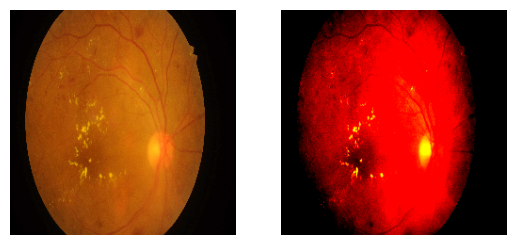

In [8]:
for i in range(1):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [9]:
class ThreeHeadCNN(nn.Module):
    def __init__(self):
        super(ThreeHeadCNN, self).__init__()

        # Load EfficientNet encoder
        weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
        efficientNet = torchvision.models.efficientnet_b1(weights=weights)
        self.encoder = efficientNet.features

        # Pooling layers
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.batch_norm_1= nn.BatchNorm1d(1280) 
        self.batch_norm_2= nn.BatchNorm1d(1280)

        self.dense1 = nn.Linear(1280 * 2, 512)


        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 5) # 5 output nodes for classification
        )

        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 1) # 1 output node is for regression
        )

        # Ordinal regression head
        self.ordinal_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 5) # 5 output nodes for ordinal regression
        )

    def forward(self, x):
        x = self.encoder(x) # Extract features

        # Apply pooling layers
        max_pooled = self.global_max_pool(x).view(x.size(0), -1)
        avg_pooled = self.global_avg_pool(x).view(x.size(0), -1)

        # Concatenate
        x1 = self.batch_norm_1(max_pooled)
        x2 = self.batch_norm_2(avg_pooled)
        x = torch.concat([x1, x2], dim=1)
        x = torch.relu(self.dense1(x))

        # enc_out for visualizing data with t-SNE
        enc_out = x

        # Classification branch
        class_out = self.classification_head(x)

        # Regression branch
        # squeeze must be done
        reg_out = self.regression_head(x).squeeze(dim=1) # Single value

        # Ordinal regression branch
        ord_out = self.ordinal_head(x)

        return class_out, reg_out, ord_out, enc_out

model = ThreeHeadCNN().to(device)

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

if load_pre_train_model:
    model.load_state_dict(torch.load("models/pre_train_model.pth", map_location=device))

    # As the paper has stated, we reinitialize the heads weights
    model.classification_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 5) # 5 output nodes for classification
                                )
    model.regression_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 1) # 5 output nodes for classification
                                )
    model.ordinal_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 5) # 5 output nodes for classification
                                )

In [11]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

Custom Focal Loss function

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=1, headType=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.headType = headType
    def forward(self, inputs, targets):
        if self.headType == 'classification':
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        if self.headType == 'ordinal':
            ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [13]:
# Define loss and optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR
# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
loss_fn_classification = FocalLoss(headType='classification').to(device)
# loss_fn_classification = nn.CrossEntropyLoss().to(device)

# loss_fn_regression = nn.L1Loss(reduction='none').to(device)
loss_fn_regression = nn.MSELoss().to(device)

# loss_fn_ordinal = nn.BCEWithLogitsLoss(weight=weights).to(device)
loss_fn_ordinal = FocalLoss(headType='ordinal').to(device)
# loss_fn_ordinal = nn.BCEWithLogitsLoss().to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.0)

  0%|          | 0/40 [00:00<?, ?it/s]C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  2%|▎         | 1/40 [00:36<23:37, 36.35s/it]

Epoch: 1
loss_classification_train: 1.0797 | loss_regression_train: 2.4326 | loss_ordinal_train: 0.3453
loss_classification_validation: 0.8498 | loss_regression_validation: 1.6305 | loss_ordinal_validation: 0.2991
acc_classification_validation: 0.6020 | acc_regression_validation: 0.5251 | acc_ordinal_validation: 0.4902



  5%|▌         | 2/40 [00:45<12:45, 20.14s/it]

Epoch: 2
loss_classification_train: 0.6843 | loss_regression_train: 0.8928 | loss_ordinal_train: 0.2413
loss_classification_validation: 0.5260 | loss_regression_validation: 0.5726 | loss_ordinal_validation: 0.1658
acc_classification_validation: 0.7446 | acc_regression_validation: 0.6077 | acc_ordinal_validation: 0.7031



  8%|▊         | 3/40 [00:53<09:14, 14.99s/it]

Epoch: 3
loss_classification_train: 0.4900 | loss_regression_train: 0.4457 | loss_ordinal_train: 0.1350
loss_classification_validation: 0.4351 | loss_regression_validation: 0.3306 | loss_ordinal_validation: 0.1026
acc_classification_validation: 0.7723 | acc_regression_validation: 0.7311 | acc_ordinal_validation: 0.7666



 10%|█         | 4/40 [01:02<07:32, 12.58s/it]

Epoch: 4
loss_classification_train: 0.3994 | loss_regression_train: 0.3504 | loss_ordinal_train: 0.0902
loss_classification_validation: 0.3410 | loss_regression_validation: 0.2748 | loss_ordinal_validation: 0.0712
acc_classification_validation: 0.8182 | acc_regression_validation: 0.7661 | acc_ordinal_validation: 0.7876



 12%|█▎        | 5/40 [01:11<06:32, 11.21s/it]

Epoch: 5
loss_classification_train: 0.3300 | loss_regression_train: 0.3144 | loss_ordinal_train: 0.0713
loss_classification_validation: 0.3710 | loss_regression_validation: 0.4052 | loss_ordinal_validation: 0.0702
acc_classification_validation: 0.8118 | acc_regression_validation: 0.7560 | acc_ordinal_validation: 0.7913



 15%|█▌        | 6/40 [01:20<05:53, 10.39s/it]

Epoch: 6
loss_classification_train: 0.3142 | loss_regression_train: 0.3032 | loss_ordinal_train: 0.0652
loss_classification_validation: 0.3282 | loss_regression_validation: 0.3362 | loss_ordinal_validation: 0.0624
acc_classification_validation: 0.8343 | acc_regression_validation: 0.7962 | acc_ordinal_validation: 0.8105



 18%|█▊        | 7/40 [01:29<05:25,  9.85s/it]

Epoch: 7
loss_classification_train: 0.2858 | loss_regression_train: 0.2790 | loss_ordinal_train: 0.0581
loss_classification_validation: 0.3322 | loss_regression_validation: 0.3190 | loss_ordinal_validation: 0.0627
acc_classification_validation: 0.8211 | acc_regression_validation: 0.7584 | acc_ordinal_validation: 0.8118



 20%|██        | 8/40 [01:38<05:05,  9.56s/it]

Epoch: 8
loss_classification_train: 0.2835 | loss_regression_train: 0.3336 | loss_ordinal_train: 0.0575
loss_classification_validation: 0.3300 | loss_regression_validation: 0.3820 | loss_ordinal_validation: 0.0623
acc_classification_validation: 0.8268 | acc_regression_validation: 0.7068 | acc_ordinal_validation: 0.8094



 22%|██▎       | 9/40 [01:46<04:48,  9.31s/it]

Epoch: 9
loss_classification_train: 0.2641 | loss_regression_train: 0.3563 | loss_ordinal_train: 0.0542
loss_classification_validation: 0.3282 | loss_regression_validation: 0.3737 | loss_ordinal_validation: 0.0617
acc_classification_validation: 0.8402 | acc_regression_validation: 0.7221 | acc_ordinal_validation: 0.8183



 25%|██▌       | 10/40 [01:55<04:35,  9.18s/it]

Epoch: 10
loss_classification_train: 0.2593 | loss_regression_train: 0.3306 | loss_ordinal_train: 0.0522
loss_classification_validation: 0.3145 | loss_regression_validation: 0.2829 | loss_ordinal_validation: 0.0585
acc_classification_validation: 0.8257 | acc_regression_validation: 0.7941 | acc_ordinal_validation: 0.8169



 28%|██▊       | 11/40 [02:05<04:26,  9.21s/it]

Epoch: 11
loss_classification_train: 0.2500 | loss_regression_train: 0.2905 | loss_ordinal_train: 0.0501
loss_classification_validation: 0.3473 | loss_regression_validation: 0.3801 | loss_ordinal_validation: 0.0617
acc_classification_validation: 0.8032 | acc_regression_validation: 0.7221 | acc_ordinal_validation: 0.8170



 30%|███       | 12/40 [02:14<04:17,  9.19s/it]

Epoch: 12
loss_classification_train: 0.2393 | loss_regression_train: 0.2638 | loss_ordinal_train: 0.0499
loss_classification_validation: 0.3252 | loss_regression_validation: 0.3300 | loss_ordinal_validation: 0.0606
acc_classification_validation: 0.8252 | acc_regression_validation: 0.7679 | acc_ordinal_validation: 0.8205



 32%|███▎      | 13/40 [02:23<04:05,  9.09s/it]

Epoch: 13
loss_classification_train: 0.2345 | loss_regression_train: 0.2850 | loss_ordinal_train: 0.0475
loss_classification_validation: 0.3149 | loss_regression_validation: 0.2753 | loss_ordinal_validation: 0.0583
acc_classification_validation: 0.8243 | acc_regression_validation: 0.7853 | acc_ordinal_validation: 0.8195



 35%|███▌      | 14/40 [02:32<03:55,  9.05s/it]

Epoch: 14
loss_classification_train: 0.2273 | loss_regression_train: 0.3334 | loss_ordinal_train: 0.0462
loss_classification_validation: 0.4297 | loss_regression_validation: 0.7441 | loss_ordinal_validation: 0.0772
acc_classification_validation: 0.7664 | acc_regression_validation: 0.6493 | acc_ordinal_validation: 0.7425



 38%|███▊      | 15/40 [02:40<03:45,  9.02s/it]

Epoch: 15
loss_classification_train: 0.2273 | loss_regression_train: 0.3463 | loss_ordinal_train: 0.0452
loss_classification_validation: 0.3840 | loss_regression_validation: 0.4142 | loss_ordinal_validation: 0.0738
acc_classification_validation: 0.8231 | acc_regression_validation: 0.7363 | acc_ordinal_validation: 0.8068



 40%|████      | 16/40 [02:49<03:35,  8.97s/it]

Epoch: 16
loss_classification_train: 0.2014 | loss_regression_train: 0.3004 | loss_ordinal_train: 0.0420
loss_classification_validation: 0.3293 | loss_regression_validation: 0.2978 | loss_ordinal_validation: 0.0621
acc_classification_validation: 0.8418 | acc_regression_validation: 0.7679 | acc_ordinal_validation: 0.8370



 42%|████▎     | 17/40 [02:58<03:25,  8.94s/it]

Epoch: 17
loss_classification_train: 0.1882 | loss_regression_train: 0.2262 | loss_ordinal_train: 0.0391
loss_classification_validation: 0.3102 | loss_regression_validation: 0.2810 | loss_ordinal_validation: 0.0572
acc_classification_validation: 0.8279 | acc_regression_validation: 0.7978 | acc_ordinal_validation: 0.8209



 45%|████▌     | 18/40 [03:07<03:18,  9.00s/it]

Epoch: 18
loss_classification_train: 0.1739 | loss_regression_train: 0.1865 | loss_ordinal_train: 0.0355
loss_classification_validation: 0.3762 | loss_regression_validation: 0.3334 | loss_ordinal_validation: 0.0677
acc_classification_validation: 0.8048 | acc_regression_validation: 0.7723 | acc_ordinal_validation: 0.8038



 48%|████▊     | 19/40 [03:16<03:08,  8.96s/it]

Epoch: 19
loss_classification_train: 0.1822 | loss_regression_train: 0.2193 | loss_ordinal_train: 0.0380
loss_classification_validation: 0.3375 | loss_regression_validation: 0.3616 | loss_ordinal_validation: 0.0630
acc_classification_validation: 0.8208 | acc_regression_validation: 0.7643 | acc_ordinal_validation: 0.8216



 50%|█████     | 20/40 [03:25<02:59,  8.95s/it]

Epoch: 20
loss_classification_train: 0.1753 | loss_regression_train: 0.2213 | loss_ordinal_train: 0.0358
loss_classification_validation: 0.3441 | loss_regression_validation: 0.2723 | loss_ordinal_validation: 0.0641
acc_classification_validation: 0.8291 | acc_regression_validation: 0.8021 | acc_ordinal_validation: 0.8221



 52%|█████▎    | 21/40 [03:34<02:50,  8.99s/it]

Epoch: 21
loss_classification_train: 0.1601 | loss_regression_train: 0.2200 | loss_ordinal_train: 0.0326
loss_classification_validation: 0.3554 | loss_regression_validation: 0.3968 | loss_ordinal_validation: 0.0680
acc_classification_validation: 0.8139 | acc_regression_validation: 0.7384 | acc_ordinal_validation: 0.8100



 55%|█████▌    | 22/40 [03:43<02:41,  8.97s/it]

Epoch: 22
loss_classification_train: 0.1671 | loss_regression_train: 0.2433 | loss_ordinal_train: 0.0337
loss_classification_validation: 0.4065 | loss_regression_validation: 0.4023 | loss_ordinal_validation: 0.0735
acc_classification_validation: 0.7677 | acc_regression_validation: 0.7125 | acc_ordinal_validation: 0.7752



 57%|█████▊    | 23/40 [03:52<02:30,  8.84s/it]

Epoch: 23
loss_classification_train: 0.1461 | loss_regression_train: 0.2162 | loss_ordinal_train: 0.0301
loss_classification_validation: 0.3536 | loss_regression_validation: 0.2760 | loss_ordinal_validation: 0.0675
acc_classification_validation: 0.8362 | acc_regression_validation: 0.8016 | acc_ordinal_validation: 0.8313



 60%|██████    | 24/40 [04:00<02:19,  8.74s/it]

Epoch: 24
loss_classification_train: 0.1533 | loss_regression_train: 0.2039 | loss_ordinal_train: 0.0318
loss_classification_validation: 0.3347 | loss_regression_validation: 0.3638 | loss_ordinal_validation: 0.0634
acc_classification_validation: 0.8369 | acc_regression_validation: 0.7511 | acc_ordinal_validation: 0.8237



 62%|██████▎   | 25/40 [04:09<02:10,  8.69s/it]

Epoch: 25
loss_classification_train: 0.1449 | loss_regression_train: 0.2085 | loss_ordinal_train: 0.0299
loss_classification_validation: 0.3727 | loss_regression_validation: 0.4054 | loss_ordinal_validation: 0.0712
acc_classification_validation: 0.8278 | acc_regression_validation: 0.7531 | acc_ordinal_validation: 0.8296



 65%|██████▌   | 26/40 [04:17<02:00,  8.61s/it]

Epoch: 26
loss_classification_train: 0.1226 | loss_regression_train: 0.1765 | loss_ordinal_train: 0.0264
loss_classification_validation: 0.4224 | loss_regression_validation: 0.3588 | loss_ordinal_validation: 0.0794
acc_classification_validation: 0.8216 | acc_regression_validation: 0.7757 | acc_ordinal_validation: 0.8190



 68%|██████▊   | 27/40 [04:26<01:51,  8.57s/it]

Epoch: 27
loss_classification_train: 0.1479 | loss_regression_train: 0.1846 | loss_ordinal_train: 0.0304
loss_classification_validation: 0.3837 | loss_regression_validation: 0.3195 | loss_ordinal_validation: 0.0728
acc_classification_validation: 0.8149 | acc_regression_validation: 0.7557 | acc_ordinal_validation: 0.8084



 70%|███████   | 28/40 [04:34<01:42,  8.53s/it]

Epoch: 28
loss_classification_train: 0.1566 | loss_regression_train: 0.2093 | loss_ordinal_train: 0.0328
loss_classification_validation: 0.4741 | loss_regression_validation: 0.3664 | loss_ordinal_validation: 0.0827
acc_classification_validation: 0.7710 | acc_regression_validation: 0.7197 | acc_ordinal_validation: 0.7700



 72%|███████▎  | 29/40 [04:43<01:35,  8.70s/it]

Epoch: 29
loss_classification_train: 0.1328 | loss_regression_train: 0.1966 | loss_ordinal_train: 0.0271
loss_classification_validation: 0.3960 | loss_regression_validation: 0.3086 | loss_ordinal_validation: 0.0727
acc_classification_validation: 0.8192 | acc_regression_validation: 0.7675 | acc_ordinal_validation: 0.8192



 75%|███████▌  | 30/40 [04:52<01:26,  8.61s/it]

Epoch: 30
loss_classification_train: 0.1277 | loss_regression_train: 0.1708 | loss_ordinal_train: 0.0261
loss_classification_validation: 0.4423 | loss_regression_validation: 0.3417 | loss_ordinal_validation: 0.0840
acc_classification_validation: 0.8081 | acc_regression_validation: 0.7731 | acc_ordinal_validation: 0.8050



 78%|███████▊  | 31/40 [05:00<01:17,  8.57s/it]

Epoch: 31
loss_classification_train: 0.1152 | loss_regression_train: 0.2232 | loss_ordinal_train: 0.0241
loss_classification_validation: 0.3788 | loss_regression_validation: 0.4545 | loss_ordinal_validation: 0.0704
acc_classification_validation: 0.8157 | acc_regression_validation: 0.7475 | acc_ordinal_validation: 0.8089



 80%|████████  | 32/40 [05:09<01:08,  8.55s/it]

Epoch: 32
loss_classification_train: 0.1136 | loss_regression_train: 0.2397 | loss_ordinal_train: 0.0233
loss_classification_validation: 0.3928 | loss_regression_validation: 0.4460 | loss_ordinal_validation: 0.0722
acc_classification_validation: 0.7708 | acc_regression_validation: 0.7128 | acc_ordinal_validation: 0.7825



 82%|████████▎ | 33/40 [05:17<00:59,  8.55s/it]

Epoch: 33
loss_classification_train: 0.1156 | loss_regression_train: 0.2525 | loss_ordinal_train: 0.0243
loss_classification_validation: 0.3682 | loss_regression_validation: 0.3608 | loss_ordinal_validation: 0.0686
acc_classification_validation: 0.8250 | acc_regression_validation: 0.7806 | acc_ordinal_validation: 0.8180



 85%|████████▌ | 34/40 [05:26<00:51,  8.55s/it]

Epoch: 34
loss_classification_train: 0.1128 | loss_regression_train: 0.2197 | loss_ordinal_train: 0.0237
loss_classification_validation: 0.4822 | loss_regression_validation: 0.3606 | loss_ordinal_validation: 0.0879
acc_classification_validation: 0.7894 | acc_regression_validation: 0.7340 | acc_ordinal_validation: 0.7920



 88%|████████▊ | 35/40 [05:34<00:42,  8.55s/it]

Epoch: 35
loss_classification_train: 0.1018 | loss_regression_train: 0.1661 | loss_ordinal_train: 0.0224
loss_classification_validation: 0.3822 | loss_regression_validation: 0.3119 | loss_ordinal_validation: 0.0734
acc_classification_validation: 0.8330 | acc_regression_validation: 0.7578 | acc_ordinal_validation: 0.8208



 90%|█████████ | 36/40 [05:43<00:33,  8.50s/it]

Epoch: 36
loss_classification_train: 0.1107 | loss_regression_train: 0.1854 | loss_ordinal_train: 0.0234
loss_classification_validation: 0.3957 | loss_regression_validation: 0.3161 | loss_ordinal_validation: 0.0749
acc_classification_validation: 0.8341 | acc_regression_validation: 0.7885 | acc_ordinal_validation: 0.8297



 92%|█████████▎| 37/40 [05:51<00:25,  8.47s/it]

Epoch: 37
loss_classification_train: 0.0978 | loss_regression_train: 0.1909 | loss_ordinal_train: 0.0219
loss_classification_validation: 0.3709 | loss_regression_validation: 0.3344 | loss_ordinal_validation: 0.0715
acc_classification_validation: 0.8375 | acc_regression_validation: 0.8027 | acc_ordinal_validation: 0.8362



 95%|█████████▌| 38/40 [05:59<00:16,  8.47s/it]

Epoch: 38
loss_classification_train: 0.0914 | loss_regression_train: 0.1622 | loss_ordinal_train: 0.0194
loss_classification_validation: 0.4178 | loss_regression_validation: 0.3932 | loss_ordinal_validation: 0.0793
acc_classification_validation: 0.8092 | acc_regression_validation: 0.7006 | acc_ordinal_validation: 0.8027



 98%|█████████▊| 39/40 [06:08<00:08,  8.46s/it]

Epoch: 39
loss_classification_train: 0.0913 | loss_regression_train: 0.1526 | loss_ordinal_train: 0.0191
loss_classification_validation: 0.4614 | loss_regression_validation: 0.4065 | loss_ordinal_validation: 0.0873
acc_classification_validation: 0.8154 | acc_regression_validation: 0.7400 | acc_ordinal_validation: 0.8154



100%|██████████| 40/40 [06:16<00:00,  9.42s/it]

Epoch: 40
loss_classification_train: 0.1190 | loss_regression_train: 0.1656 | loss_ordinal_train: 0.0243
loss_classification_validation: 0.4136 | loss_regression_validation: 0.2882 | loss_ordinal_validation: 0.0799
acc_classification_validation: 0.8385 | acc_regression_validation: 0.8141 | acc_ordinal_validation: 0.8328



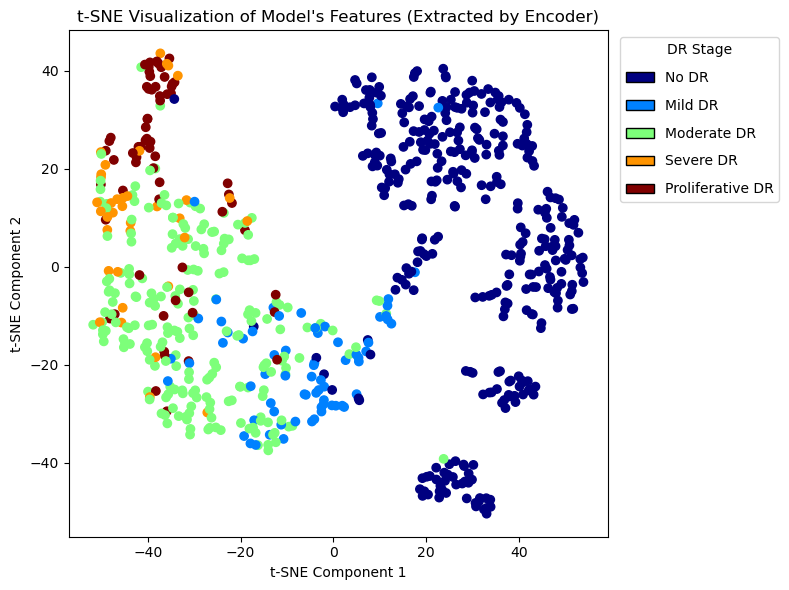

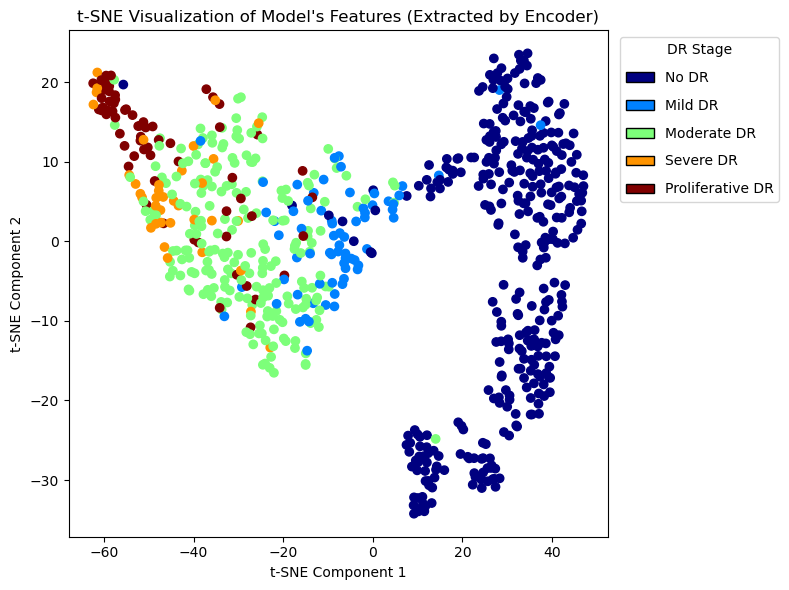

  2%|▎         | 1/40 [00:36<23:33, 36.24s/it]

Epoch: 1
loss_classification_train: 0.1642 | loss_regression_train: 0.1827 | loss_ordinal_train: 0.0335
loss_classification_validation: 0.0913 | loss_regression_validation: 0.1120 | loss_ordinal_validation: 0.0187
acc_classification_validation: 0.9438 | acc_regression_validation: 0.9100 | acc_ordinal_validation: 0.9455



  5%|▌         | 2/40 [00:44<12:30, 19.74s/it]

Epoch: 2
loss_classification_train: 0.1370 | loss_regression_train: 0.1661 | loss_ordinal_train: 0.0275
loss_classification_validation: 0.0825 | loss_regression_validation: 0.1419 | loss_ordinal_validation: 0.0178
acc_classification_validation: 0.9526 | acc_regression_validation: 0.8802 | acc_ordinal_validation: 0.9500



  8%|▊         | 3/40 [00:52<09:01, 14.63s/it]

Epoch: 3
loss_classification_train: 0.1357 | loss_regression_train: 0.1788 | loss_ordinal_train: 0.0286
loss_classification_validation: 0.0855 | loss_regression_validation: 0.0890 | loss_ordinal_validation: 0.0176
acc_classification_validation: 0.9508 | acc_regression_validation: 0.9359 | acc_ordinal_validation: 0.9481



 10%|█         | 4/40 [01:01<07:23, 12.33s/it]

Epoch: 4
loss_classification_train: 0.1181 | loss_regression_train: 0.1925 | loss_ordinal_train: 0.0250
loss_classification_validation: 0.0994 | loss_regression_validation: 0.2219 | loss_ordinal_validation: 0.0222
acc_classification_validation: 0.9434 | acc_regression_validation: 0.8322 | acc_ordinal_validation: 0.9329



 12%|█▎        | 5/40 [01:10<06:27, 11.07s/it]

Epoch: 5
loss_classification_train: 0.1042 | loss_regression_train: 0.1702 | loss_ordinal_train: 0.0219
loss_classification_validation: 0.0988 | loss_regression_validation: 0.1599 | loss_ordinal_validation: 0.0208
acc_classification_validation: 0.9377 | acc_regression_validation: 0.8729 | acc_ordinal_validation: 0.9324



 15%|█▌        | 6/40 [01:19<05:49, 10.29s/it]

Epoch: 6
loss_classification_train: 0.1107 | loss_regression_train: 0.1629 | loss_ordinal_train: 0.0230
loss_classification_validation: 0.0865 | loss_regression_validation: 0.1303 | loss_ordinal_validation: 0.0175
acc_classification_validation: 0.9499 | acc_regression_validation: 0.8913 | acc_ordinal_validation: 0.9473



 18%|█▊        | 7/40 [01:28<05:23,  9.81s/it]

Epoch: 7
loss_classification_train: 0.0969 | loss_regression_train: 0.1877 | loss_ordinal_train: 0.0214
loss_classification_validation: 0.1080 | loss_regression_validation: 0.1076 | loss_ordinal_validation: 0.0219
acc_classification_validation: 0.9403 | acc_regression_validation: 0.9171 | acc_ordinal_validation: 0.9359



 20%|██        | 8/40 [01:37<05:03,  9.50s/it]

Epoch: 8
loss_classification_train: 0.1035 | loss_regression_train: 0.1833 | loss_ordinal_train: 0.0208
loss_classification_validation: 0.1670 | loss_regression_validation: 0.2233 | loss_ordinal_validation: 0.0338
acc_classification_validation: 0.9031 | acc_regression_validation: 0.8276 | acc_ordinal_validation: 0.8987



 22%|██▎       | 9/40 [01:45<04:48,  9.30s/it]

Epoch: 9
loss_classification_train: 0.0981 | loss_regression_train: 0.1812 | loss_ordinal_train: 0.0209
loss_classification_validation: 0.1246 | loss_regression_validation: 0.2041 | loss_ordinal_validation: 0.0252
acc_classification_validation: 0.9197 | acc_regression_validation: 0.8004 | acc_ordinal_validation: 0.9114



 25%|██▌       | 10/40 [01:54<04:35,  9.19s/it]

Epoch: 10
loss_classification_train: 0.1130 | loss_regression_train: 0.2140 | loss_ordinal_train: 0.0234
loss_classification_validation: 0.1370 | loss_regression_validation: 0.1289 | loss_ordinal_validation: 0.0280
acc_classification_validation: 0.9074 | acc_regression_validation: 0.9084 | acc_ordinal_validation: 0.9066



 28%|██▊       | 11/40 [02:03<04:19,  8.96s/it]

Epoch: 11
loss_classification_train: 0.1120 | loss_regression_train: 0.1985 | loss_ordinal_train: 0.0229
loss_classification_validation: 0.1527 | loss_regression_validation: 0.2594 | loss_ordinal_validation: 0.0313
acc_classification_validation: 0.8996 | acc_regression_validation: 0.8256 | acc_ordinal_validation: 0.8983



 30%|███       | 12/40 [02:11<04:05,  8.77s/it]

Epoch: 12
loss_classification_train: 0.0946 | loss_regression_train: 0.1925 | loss_ordinal_train: 0.0206
loss_classification_validation: 0.1059 | loss_regression_validation: 0.2085 | loss_ordinal_validation: 0.0226
acc_classification_validation: 0.9354 | acc_regression_validation: 0.8141 | acc_ordinal_validation: 0.9284



 32%|███▎      | 13/40 [02:19<03:52,  8.63s/it]

Epoch: 13
loss_classification_train: 0.0931 | loss_regression_train: 0.1699 | loss_ordinal_train: 0.0187
loss_classification_validation: 0.1449 | loss_regression_validation: 0.1392 | loss_ordinal_validation: 0.0330
acc_classification_validation: 0.9261 | acc_regression_validation: 0.8769 | acc_ordinal_validation: 0.9181



 35%|███▌      | 14/40 [02:28<03:41,  8.51s/it]

Epoch: 14
loss_classification_train: 0.0813 | loss_regression_train: 0.1868 | loss_ordinal_train: 0.0182
loss_classification_validation: 0.1618 | loss_regression_validation: 0.1898 | loss_ordinal_validation: 0.0344
acc_classification_validation: 0.9066 | acc_regression_validation: 0.8507 | acc_ordinal_validation: 0.8974



 38%|███▊      | 15/40 [02:36<03:30,  8.44s/it]

Epoch: 15
loss_classification_train: 0.0719 | loss_regression_train: 0.1312 | loss_ordinal_train: 0.0172
loss_classification_validation: 0.1568 | loss_regression_validation: 0.1348 | loss_ordinal_validation: 0.0329
acc_classification_validation: 0.9183 | acc_regression_validation: 0.8882 | acc_ordinal_validation: 0.9157



 40%|████      | 16/40 [02:44<03:21,  8.39s/it]

Epoch: 16
loss_classification_train: 0.0708 | loss_regression_train: 0.1121 | loss_ordinal_train: 0.0157
loss_classification_validation: 0.1403 | loss_regression_validation: 0.1215 | loss_ordinal_validation: 0.0303
acc_classification_validation: 0.9364 | acc_regression_validation: 0.9149 | acc_ordinal_validation: 0.9294



 42%|████▎     | 17/40 [02:53<03:12,  8.36s/it]

Epoch: 17
loss_classification_train: 0.0765 | loss_regression_train: 0.1041 | loss_ordinal_train: 0.0157
loss_classification_validation: 0.1349 | loss_regression_validation: 0.1268 | loss_ordinal_validation: 0.0282
acc_classification_validation: 0.9263 | acc_regression_validation: 0.8947 | acc_ordinal_validation: 0.9170



 45%|████▌     | 18/40 [03:01<03:02,  8.31s/it]

Epoch: 18
loss_classification_train: 0.0595 | loss_regression_train: 0.1204 | loss_ordinal_train: 0.0134
loss_classification_validation: 0.1514 | loss_regression_validation: 0.2157 | loss_ordinal_validation: 0.0324
acc_classification_validation: 0.9254 | acc_regression_validation: 0.8364 | acc_ordinal_validation: 0.9176



 48%|████▊     | 19/40 [03:09<02:54,  8.31s/it]

Epoch: 19
loss_classification_train: 0.0757 | loss_regression_train: 0.1336 | loss_ordinal_train: 0.0167
loss_classification_validation: 0.1571 | loss_regression_validation: 0.2044 | loss_ordinal_validation: 0.0326
acc_classification_validation: 0.9080 | acc_regression_validation: 0.8625 | acc_ordinal_validation: 0.9085



 50%|█████     | 20/40 [03:17<02:45,  8.28s/it]

Epoch: 20
loss_classification_train: 0.0733 | loss_regression_train: 0.1556 | loss_ordinal_train: 0.0156
loss_classification_validation: 0.1656 | loss_regression_validation: 0.1443 | loss_ordinal_validation: 0.0340
acc_classification_validation: 0.9210 | acc_regression_validation: 0.8914 | acc_ordinal_validation: 0.9145



 52%|█████▎    | 21/40 [03:26<02:37,  8.29s/it]

Epoch: 21
loss_classification_train: 0.0650 | loss_regression_train: 0.1965 | loss_ordinal_train: 0.0150
loss_classification_validation: 0.1679 | loss_regression_validation: 0.3498 | loss_ordinal_validation: 0.0374
acc_classification_validation: 0.9010 | acc_regression_validation: 0.7605 | acc_ordinal_validation: 0.8997



 55%|█████▌    | 22/40 [03:34<02:29,  8.28s/it]

Epoch: 22
loss_classification_train: 0.0827 | loss_regression_train: 0.2515 | loss_ordinal_train: 0.0176
loss_classification_validation: 0.1630 | loss_regression_validation: 0.2746 | loss_ordinal_validation: 0.0350
acc_classification_validation: 0.9266 | acc_regression_validation: 0.8258 | acc_ordinal_validation: 0.9245



 57%|█████▊    | 23/40 [03:42<02:21,  8.30s/it]

Epoch: 23
loss_classification_train: 0.0708 | loss_regression_train: 0.2451 | loss_ordinal_train: 0.0163
loss_classification_validation: 0.1778 | loss_regression_validation: 0.1510 | loss_ordinal_validation: 0.0374
acc_classification_validation: 0.9087 | acc_regression_validation: 0.8856 | acc_ordinal_validation: 0.9017



 60%|██████    | 24/40 [03:50<02:12,  8.29s/it]

Epoch: 24
loss_classification_train: 0.0897 | loss_regression_train: 0.2085 | loss_ordinal_train: 0.0185
loss_classification_validation: 0.2124 | loss_regression_validation: 0.3695 | loss_ordinal_validation: 0.0443
acc_classification_validation: 0.8843 | acc_regression_validation: 0.7237 | acc_ordinal_validation: 0.8843



 62%|██████▎   | 25/40 [03:59<02:04,  8.28s/it]

Epoch: 25
loss_classification_train: 0.0882 | loss_regression_train: 0.1970 | loss_ordinal_train: 0.0183
loss_classification_validation: 0.1735 | loss_regression_validation: 0.2472 | loss_ordinal_validation: 0.0356
acc_classification_validation: 0.8917 | acc_regression_validation: 0.7303 | acc_ordinal_validation: 0.8943



 65%|██████▌   | 26/40 [04:07<01:56,  8.30s/it]

Epoch: 26
loss_classification_train: 0.0708 | loss_regression_train: 0.1421 | loss_ordinal_train: 0.0150
loss_classification_validation: 0.2029 | loss_regression_validation: 0.1804 | loss_ordinal_validation: 0.0409
acc_classification_validation: 0.9080 | acc_regression_validation: 0.8537 | acc_ordinal_validation: 0.9067



 68%|██████▊   | 27/40 [04:15<01:47,  8.30s/it]

Epoch: 27
loss_classification_train: 0.0701 | loss_regression_train: 0.1091 | loss_ordinal_train: 0.0147
loss_classification_validation: 0.1705 | loss_regression_validation: 0.1548 | loss_ordinal_validation: 0.0366
acc_classification_validation: 0.9154 | acc_regression_validation: 0.8730 | acc_ordinal_validation: 0.9079



 70%|███████   | 28/40 [04:24<01:39,  8.30s/it]

Epoch: 28
loss_classification_train: 0.0560 | loss_regression_train: 0.1013 | loss_ordinal_train: 0.0127
loss_classification_validation: 0.1922 | loss_regression_validation: 0.1399 | loss_ordinal_validation: 0.0397
acc_classification_validation: 0.9049 | acc_regression_validation: 0.8831 | acc_ordinal_validation: 0.8953



 72%|███████▎  | 29/40 [04:32<01:31,  8.31s/it]

Epoch: 29
loss_classification_train: 0.0621 | loss_regression_train: 0.1055 | loss_ordinal_train: 0.0140
loss_classification_validation: 0.1925 | loss_regression_validation: 0.1600 | loss_ordinal_validation: 0.0398
acc_classification_validation: 0.9088 | acc_regression_validation: 0.8911 | acc_ordinal_validation: 0.9119



 75%|███████▌  | 30/40 [04:40<01:23,  8.31s/it]

Epoch: 30
loss_classification_train: 0.0576 | loss_regression_train: 0.0887 | loss_ordinal_train: 0.0128
loss_classification_validation: 0.1849 | loss_regression_validation: 0.1395 | loss_ordinal_validation: 0.0380
acc_classification_validation: 0.9105 | acc_regression_validation: 0.8870 | acc_ordinal_validation: 0.9084



 78%|███████▊  | 31/40 [04:49<01:14,  8.32s/it]

Epoch: 31
loss_classification_train: 0.0574 | loss_regression_train: 0.0984 | loss_ordinal_train: 0.0127
loss_classification_validation: 0.1887 | loss_regression_validation: 0.1615 | loss_ordinal_validation: 0.0373
acc_classification_validation: 0.9111 | acc_regression_validation: 0.8836 | acc_ordinal_validation: 0.9124



 80%|████████  | 32/40 [04:57<01:06,  8.32s/it]

Epoch: 32
loss_classification_train: 0.0580 | loss_regression_train: 0.1054 | loss_ordinal_train: 0.0129
loss_classification_validation: 0.2253 | loss_regression_validation: 0.1807 | loss_ordinal_validation: 0.0447
acc_classification_validation: 0.8979 | acc_regression_validation: 0.8745 | acc_ordinal_validation: 0.8914



 82%|████████▎ | 33/40 [05:05<00:58,  8.33s/it]

Epoch: 33
loss_classification_train: 0.0679 | loss_regression_train: 0.1193 | loss_ordinal_train: 0.0142
loss_classification_validation: 0.2103 | loss_regression_validation: 0.1733 | loss_ordinal_validation: 0.0430
acc_classification_validation: 0.8976 | acc_regression_validation: 0.8719 | acc_ordinal_validation: 0.8963



 85%|████████▌ | 34/40 [05:14<00:50,  8.36s/it]

Epoch: 34
loss_classification_train: 0.0548 | loss_regression_train: 0.1372 | loss_ordinal_train: 0.0122
loss_classification_validation: 0.2084 | loss_regression_validation: 0.2069 | loss_ordinal_validation: 0.0430
acc_classification_validation: 0.9020 | acc_regression_validation: 0.8618 | acc_ordinal_validation: 0.9046



 88%|████████▊ | 35/40 [05:22<00:41,  8.34s/it]

Epoch: 35
loss_classification_train: 0.0649 | loss_regression_train: 0.1601 | loss_ordinal_train: 0.0141
loss_classification_validation: 0.2216 | loss_regression_validation: 0.1942 | loss_ordinal_validation: 0.0503
acc_classification_validation: 0.9129 | acc_regression_validation: 0.8701 | acc_ordinal_validation: 0.9072



 90%|█████████ | 36/40 [05:30<00:33,  8.27s/it]

Epoch: 36
loss_classification_train: 0.0664 | loss_regression_train: 0.1601 | loss_ordinal_train: 0.0154
loss_classification_validation: 0.2105 | loss_regression_validation: 0.1882 | loss_ordinal_validation: 0.0453
acc_classification_validation: 0.8913 | acc_regression_validation: 0.8779 | acc_ordinal_validation: 0.8961



 92%|█████████▎| 37/40 [05:38<00:24,  8.24s/it]

Epoch: 37
loss_classification_train: 0.0587 | loss_regression_train: 0.1518 | loss_ordinal_train: 0.0125
loss_classification_validation: 0.2001 | loss_regression_validation: 0.1753 | loss_ordinal_validation: 0.0376
acc_classification_validation: 0.9023 | acc_regression_validation: 0.8636 | acc_ordinal_validation: 0.8953



 95%|█████████▌| 38/40 [05:46<00:16,  8.24s/it]

Epoch: 38
loss_classification_train: 0.0606 | loss_regression_train: 0.1378 | loss_ordinal_train: 0.0136
loss_classification_validation: 0.2095 | loss_regression_validation: 0.1520 | loss_ordinal_validation: 0.0407
acc_classification_validation: 0.9031 | acc_regression_validation: 0.8733 | acc_ordinal_validation: 0.8992



 98%|█████████▊| 39/40 [05:55<00:08,  8.22s/it]

Epoch: 39
loss_classification_train: 0.0559 | loss_regression_train: 0.0959 | loss_ordinal_train: 0.0131
loss_classification_validation: 0.2102 | loss_regression_validation: 0.1552 | loss_ordinal_validation: 0.0413
acc_classification_validation: 0.9101 | acc_regression_validation: 0.8642 | acc_ordinal_validation: 0.9035



100%|██████████| 40/40 [06:03<00:00,  9.08s/it]

Epoch: 40
loss_classification_train: 0.0490 | loss_regression_train: 0.0923 | loss_ordinal_train: 0.0109
loss_classification_validation: 0.2485 | loss_regression_validation: 0.1932 | loss_ordinal_validation: 0.0528
acc_classification_validation: 0.8934 | acc_regression_validation: 0.8606 | acc_ordinal_validation: 0.8890



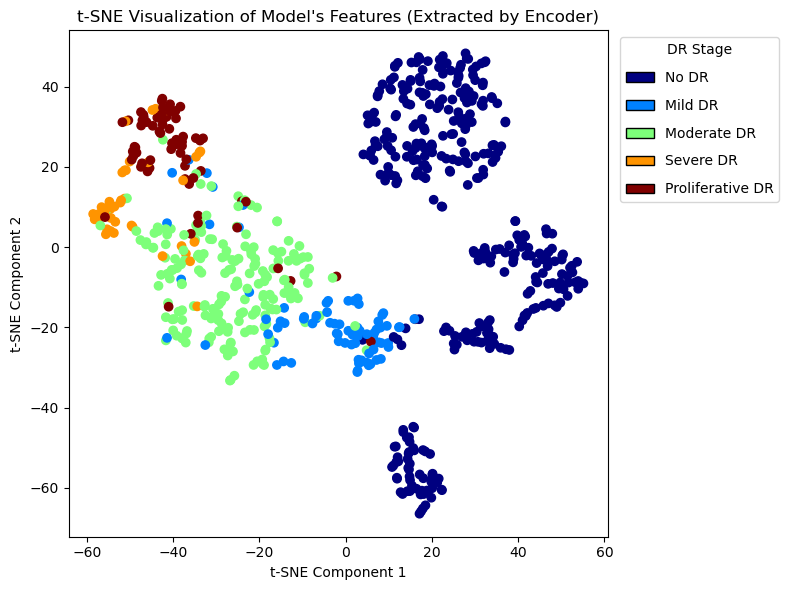

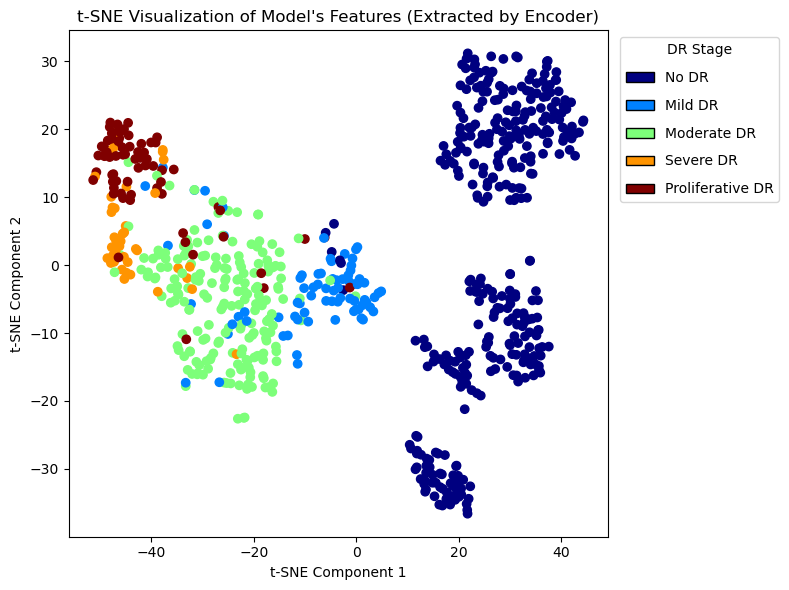

  2%|▎         | 1/40 [00:34<22:43, 34.96s/it]

Epoch: 1
loss_classification_train: 0.0914 | loss_regression_train: 0.1119 | loss_ordinal_train: 0.0205
loss_classification_validation: 0.0554 | loss_regression_validation: 0.0985 | loss_ordinal_validation: 0.0123
acc_classification_validation: 0.9641 | acc_regression_validation: 0.9196 | acc_ordinal_validation: 0.9615



  5%|▌         | 2/40 [00:43<12:15, 19.35s/it]

Epoch: 2
loss_classification_train: 0.0745 | loss_regression_train: 0.1328 | loss_ordinal_train: 0.0159
loss_classification_validation: 0.0515 | loss_regression_validation: 0.1190 | loss_ordinal_validation: 0.0124
acc_classification_validation: 0.9638 | acc_regression_validation: 0.9245 | acc_ordinal_validation: 0.9612



  8%|▊         | 3/40 [00:51<08:52, 14.39s/it]

Epoch: 3
loss_classification_train: 0.0862 | loss_regression_train: 0.1483 | loss_ordinal_train: 0.0187
loss_classification_validation: 0.0726 | loss_regression_validation: 0.0807 | loss_ordinal_validation: 0.0167
acc_classification_validation: 0.9620 | acc_regression_validation: 0.9436 | acc_ordinal_validation: 0.9576



 10%|█         | 4/40 [01:00<07:14, 12.06s/it]

Epoch: 4
loss_classification_train: 0.0790 | loss_regression_train: 0.1771 | loss_ordinal_train: 0.0172
loss_classification_validation: 0.0927 | loss_regression_validation: 0.2382 | loss_ordinal_validation: 0.0188
acc_classification_validation: 0.9464 | acc_regression_validation: 0.6990 | acc_ordinal_validation: 0.9490



 12%|█▎        | 5/40 [01:08<06:15, 10.73s/it]

Epoch: 5
loss_classification_train: 0.0814 | loss_regression_train: 0.2195 | loss_ordinal_train: 0.0179
loss_classification_validation: 0.0737 | loss_regression_validation: 0.2868 | loss_ordinal_validation: 0.0177
acc_classification_validation: 0.9519 | acc_regression_validation: 0.6875 | acc_ordinal_validation: 0.9441



 15%|█▌        | 6/40 [01:17<05:37,  9.94s/it]

Epoch: 6
loss_classification_train: 0.1108 | loss_regression_train: 0.2639 | loss_ordinal_train: 0.0233
loss_classification_validation: 0.1102 | loss_regression_validation: 0.2648 | loss_ordinal_validation: 0.0220
acc_classification_validation: 0.9189 | acc_regression_validation: 0.7196 | acc_ordinal_validation: 0.9342



 18%|█▊        | 7/40 [01:25<05:09,  9.37s/it]

Epoch: 7
loss_classification_train: 0.0708 | loss_regression_train: 0.2138 | loss_ordinal_train: 0.0153
loss_classification_validation: 0.0619 | loss_regression_validation: 0.1149 | loss_ordinal_validation: 0.0150
acc_classification_validation: 0.9571 | acc_regression_validation: 0.9433 | acc_ordinal_validation: 0.9581



 20%|██        | 8/40 [01:33<04:48,  9.02s/it]

Epoch: 8
loss_classification_train: 0.0827 | loss_regression_train: 0.2009 | loss_ordinal_train: 0.0167
loss_classification_validation: 0.1038 | loss_regression_validation: 0.2006 | loss_ordinal_validation: 0.0176
acc_classification_validation: 0.9501 | acc_regression_validation: 0.8635 | acc_ordinal_validation: 0.9519



 22%|██▎       | 9/40 [01:41<04:32,  8.80s/it]

Epoch: 9
loss_classification_train: 0.0748 | loss_regression_train: 0.1721 | loss_ordinal_train: 0.0163
loss_classification_validation: 0.1046 | loss_regression_validation: 0.1292 | loss_ordinal_validation: 0.0228
acc_classification_validation: 0.9350 | acc_regression_validation: 0.9159 | acc_ordinal_validation: 0.9389



 25%|██▌       | 10/40 [01:50<04:19,  8.65s/it]

Epoch: 10
loss_classification_train: 0.0665 | loss_regression_train: 0.1054 | loss_ordinal_train: 0.0145
loss_classification_validation: 0.0833 | loss_regression_validation: 0.0971 | loss_ordinal_validation: 0.0198
acc_classification_validation: 0.9578 | acc_regression_validation: 0.9378 | acc_ordinal_validation: 0.9604



 28%|██▊       | 11/40 [01:58<04:07,  8.55s/it]

Epoch: 11
loss_classification_train: 0.0554 | loss_regression_train: 0.0918 | loss_ordinal_train: 0.0118
loss_classification_validation: 0.0699 | loss_regression_validation: 0.0805 | loss_ordinal_validation: 0.0158
acc_classification_validation: 0.9607 | acc_regression_validation: 0.9490 | acc_ordinal_validation: 0.9581



 30%|███       | 12/40 [02:06<03:57,  8.48s/it]

Epoch: 12
loss_classification_train: 0.0581 | loss_regression_train: 0.0913 | loss_ordinal_train: 0.0126
loss_classification_validation: 0.0977 | loss_regression_validation: 0.1245 | loss_ordinal_validation: 0.0246
acc_classification_validation: 0.9503 | acc_regression_validation: 0.9217 | acc_ordinal_validation: 0.9464



 32%|███▎      | 13/40 [02:15<03:47,  8.43s/it]

Epoch: 13
loss_classification_train: 0.0514 | loss_regression_train: 0.0944 | loss_ordinal_train: 0.0123
loss_classification_validation: 0.0908 | loss_regression_validation: 0.1006 | loss_ordinal_validation: 0.0206
acc_classification_validation: 0.9464 | acc_regression_validation: 0.9353 | acc_ordinal_validation: 0.9420



 35%|███▌      | 14/40 [02:23<03:38,  8.42s/it]

Epoch: 14
loss_classification_train: 0.0574 | loss_regression_train: 0.0962 | loss_ordinal_train: 0.0130
loss_classification_validation: 0.1016 | loss_regression_validation: 0.1271 | loss_ordinal_validation: 0.0226
acc_classification_validation: 0.9446 | acc_regression_validation: 0.9218 | acc_ordinal_validation: 0.9407



 38%|███▊      | 15/40 [02:31<03:29,  8.37s/it]

Epoch: 15
loss_classification_train: 0.0482 | loss_regression_train: 0.0890 | loss_ordinal_train: 0.0107
loss_classification_validation: 0.0919 | loss_regression_validation: 0.1196 | loss_ordinal_validation: 0.0194
acc_classification_validation: 0.9555 | acc_regression_validation: 0.9464 | acc_ordinal_validation: 0.9594



 40%|████      | 16/40 [02:40<03:20,  8.35s/it]

Epoch: 16
loss_classification_train: 0.0451 | loss_regression_train: 0.0930 | loss_ordinal_train: 0.0100
loss_classification_validation: 0.0799 | loss_regression_validation: 0.1238 | loss_ordinal_validation: 0.0197
acc_classification_validation: 0.9550 | acc_regression_validation: 0.9457 | acc_ordinal_validation: 0.9514



 42%|████▎     | 17/40 [02:48<03:11,  8.33s/it]

Epoch: 17
loss_classification_train: 0.0472 | loss_regression_train: 0.1064 | loss_ordinal_train: 0.0103
loss_classification_validation: 0.0888 | loss_regression_validation: 0.0944 | loss_ordinal_validation: 0.0195
acc_classification_validation: 0.9516 | acc_regression_validation: 0.9363 | acc_ordinal_validation: 0.9495



 45%|████▌     | 18/40 [02:56<03:03,  8.33s/it]

Epoch: 18
loss_classification_train: 0.0466 | loss_regression_train: 0.0801 | loss_ordinal_train: 0.0098
loss_classification_validation: 0.1163 | loss_regression_validation: 0.1161 | loss_ordinal_validation: 0.0261
acc_classification_validation: 0.9423 | acc_regression_validation: 0.9147 | acc_ordinal_validation: 0.9470



 48%|████▊     | 19/40 [03:04<02:54,  8.30s/it]

Epoch: 19
loss_classification_train: 0.0502 | loss_regression_train: 0.1117 | loss_ordinal_train: 0.0112
loss_classification_validation: 0.1431 | loss_regression_validation: 0.2119 | loss_ordinal_validation: 0.0347
acc_classification_validation: 0.9279 | acc_regression_validation: 0.8548 | acc_ordinal_validation: 0.9295



 50%|█████     | 20/40 [03:13<02:45,  8.28s/it]

Epoch: 20
loss_classification_train: 0.0632 | loss_regression_train: 0.1816 | loss_ordinal_train: 0.0137
loss_classification_validation: 0.0971 | loss_regression_validation: 0.1117 | loss_ordinal_validation: 0.0223
acc_classification_validation: 0.9384 | acc_regression_validation: 0.9288 | acc_ordinal_validation: 0.9363



 52%|█████▎    | 21/40 [03:21<02:37,  8.29s/it]

Epoch: 21
loss_classification_train: 0.0519 | loss_regression_train: 0.1841 | loss_ordinal_train: 0.0115
loss_classification_validation: 0.1523 | loss_regression_validation: 0.2143 | loss_ordinal_validation: 0.0280
acc_classification_validation: 0.9241 | acc_regression_validation: 0.8465 | acc_ordinal_validation: 0.9260



 55%|█████▌    | 22/40 [03:29<02:29,  8.29s/it]

Epoch: 22
loss_classification_train: 0.0576 | loss_regression_train: 0.1777 | loss_ordinal_train: 0.0120
loss_classification_validation: 0.1178 | loss_regression_validation: 0.1756 | loss_ordinal_validation: 0.0268
acc_classification_validation: 0.9462 | acc_regression_validation: 0.8847 | acc_ordinal_validation: 0.9449



 57%|█████▊    | 23/40 [03:38<02:21,  8.31s/it]

Epoch: 23
loss_classification_train: 0.0570 | loss_regression_train: 0.1317 | loss_ordinal_train: 0.0125
loss_classification_validation: 0.1531 | loss_regression_validation: 0.1425 | loss_ordinal_validation: 0.0329
acc_classification_validation: 0.9295 | acc_regression_validation: 0.9099 | acc_ordinal_validation: 0.9282



 60%|██████    | 24/40 [03:46<02:13,  8.32s/it]

Epoch: 24
loss_classification_train: 0.0601 | loss_regression_train: 0.1185 | loss_ordinal_train: 0.0123
loss_classification_validation: 0.1261 | loss_regression_validation: 0.1661 | loss_ordinal_validation: 0.0283
acc_classification_validation: 0.9360 | acc_regression_validation: 0.8965 | acc_ordinal_validation: 0.9347



 62%|██████▎   | 25/40 [03:54<02:05,  8.34s/it]

Epoch: 25
loss_classification_train: 0.0380 | loss_regression_train: 0.0976 | loss_ordinal_train: 0.0081
loss_classification_validation: 0.1171 | loss_regression_validation: 0.1497 | loss_ordinal_validation: 0.0283
acc_classification_validation: 0.9391 | acc_regression_validation: 0.8766 | acc_ordinal_validation: 0.9360



 65%|██████▌   | 26/40 [04:03<01:57,  8.36s/it]

Epoch: 26
loss_classification_train: 0.0425 | loss_regression_train: 0.0911 | loss_ordinal_train: 0.0091
loss_classification_validation: 0.1268 | loss_regression_validation: 0.1297 | loss_ordinal_validation: 0.0285
acc_classification_validation: 0.9381 | acc_regression_validation: 0.8957 | acc_ordinal_validation: 0.9381



 68%|██████▊   | 27/40 [04:11<01:48,  8.34s/it]

Epoch: 27
loss_classification_train: 0.0448 | loss_regression_train: 0.0905 | loss_ordinal_train: 0.0094
loss_classification_validation: 0.0910 | loss_regression_validation: 0.0867 | loss_ordinal_validation: 0.0210
acc_classification_validation: 0.9597 | acc_regression_validation: 0.9334 | acc_ordinal_validation: 0.9553



 70%|███████   | 28/40 [04:19<01:39,  8.33s/it]

Epoch: 28
loss_classification_train: 0.0363 | loss_regression_train: 0.0798 | loss_ordinal_train: 0.0076
loss_classification_validation: 0.1645 | loss_regression_validation: 0.1462 | loss_ordinal_validation: 0.0377
acc_classification_validation: 0.9269 | acc_regression_validation: 0.9134 | acc_ordinal_validation: 0.9256



 72%|███████▎  | 29/40 [04:28<01:31,  8.32s/it]

Epoch: 29
loss_classification_train: 0.0424 | loss_regression_train: 0.0878 | loss_ordinal_train: 0.0094
loss_classification_validation: 0.2055 | loss_regression_validation: 0.1748 | loss_ordinal_validation: 0.0454
acc_classification_validation: 0.9121 | acc_regression_validation: 0.8933 | acc_ordinal_validation: 0.9069



 75%|███████▌  | 30/40 [04:36<01:23,  8.34s/it]

Epoch: 30
loss_classification_train: 0.0448 | loss_regression_train: 0.1000 | loss_ordinal_train: 0.0115
loss_classification_validation: 0.1381 | loss_regression_validation: 0.1249 | loss_ordinal_validation: 0.0299
acc_classification_validation: 0.9396 | acc_regression_validation: 0.9027 | acc_ordinal_validation: 0.9370



 78%|███████▊  | 31/40 [04:45<01:15,  8.37s/it]

Epoch: 31
loss_classification_train: 0.0511 | loss_regression_train: 0.0953 | loss_ordinal_train: 0.0118
loss_classification_validation: 0.1910 | loss_regression_validation: 0.2043 | loss_ordinal_validation: 0.0425
acc_classification_validation: 0.8993 | acc_regression_validation: 0.8718 | acc_ordinal_validation: 0.8999



 80%|████████  | 32/40 [04:53<01:07,  8.44s/it]

Epoch: 32
loss_classification_train: 0.0564 | loss_regression_train: 0.1285 | loss_ordinal_train: 0.0123
loss_classification_validation: 0.1763 | loss_regression_validation: 0.2685 | loss_ordinal_validation: 0.0370
acc_classification_validation: 0.9134 | acc_regression_validation: 0.8226 | acc_ordinal_validation: 0.9173



 82%|████████▎ | 33/40 [05:02<00:59,  8.44s/it]

Epoch: 33
loss_classification_train: 0.0351 | loss_regression_train: 0.1260 | loss_ordinal_train: 0.0078
loss_classification_validation: 0.1702 | loss_regression_validation: 0.1714 | loss_ordinal_validation: 0.0350
acc_classification_validation: 0.9269 | acc_regression_validation: 0.8852 | acc_ordinal_validation: 0.9248



 85%|████████▌ | 34/40 [05:10<00:50,  8.44s/it]

Epoch: 34
loss_classification_train: 0.0386 | loss_regression_train: 0.1186 | loss_ordinal_train: 0.0084
loss_classification_validation: 0.1679 | loss_regression_validation: 0.1502 | loss_ordinal_validation: 0.0340
acc_classification_validation: 0.9227 | acc_regression_validation: 0.9107 | acc_ordinal_validation: 0.9206



 88%|████████▊ | 35/40 [05:18<00:42,  8.44s/it]

Epoch: 35
loss_classification_train: 0.0455 | loss_regression_train: 0.0958 | loss_ordinal_train: 0.0092
loss_classification_validation: 0.2586 | loss_regression_validation: 0.1699 | loss_ordinal_validation: 0.0572
acc_classification_validation: 0.9045 | acc_regression_validation: 0.8871 | acc_ordinal_validation: 0.9006



 90%|█████████ | 36/40 [05:27<00:33,  8.41s/it]

Epoch: 36
loss_classification_train: 0.0533 | loss_regression_train: 0.0868 | loss_ordinal_train: 0.0122
loss_classification_validation: 0.1724 | loss_regression_validation: 0.1463 | loss_ordinal_validation: 0.0356
acc_classification_validation: 0.9123 | acc_regression_validation: 0.8998 | acc_ordinal_validation: 0.9071



 92%|█████████▎| 37/40 [05:35<00:25,  8.38s/it]

Epoch: 37
loss_classification_train: 0.0509 | loss_regression_train: 0.1092 | loss_ordinal_train: 0.0112
loss_classification_validation: 0.1507 | loss_regression_validation: 0.1667 | loss_ordinal_validation: 0.0319
acc_classification_validation: 0.9326 | acc_regression_validation: 0.8972 | acc_ordinal_validation: 0.9352



 95%|█████████▌| 38/40 [05:43<00:16,  8.35s/it]

Epoch: 38
loss_classification_train: 0.0496 | loss_regression_train: 0.1461 | loss_ordinal_train: 0.0108
loss_classification_validation: 0.2765 | loss_regression_validation: 0.2833 | loss_ordinal_validation: 0.0543
acc_classification_validation: 0.8868 | acc_regression_validation: 0.8114 | acc_ordinal_validation: 0.8842



 98%|█████████▊| 39/40 [05:52<00:08,  8.36s/it]

Epoch: 39
loss_classification_train: 0.0449 | loss_regression_train: 0.1664 | loss_ordinal_train: 0.0087
loss_classification_validation: 0.1741 | loss_regression_validation: 0.2765 | loss_ordinal_validation: 0.0392
acc_classification_validation: 0.9152 | acc_regression_validation: 0.8397 | acc_ordinal_validation: 0.9126



100%|██████████| 40/40 [06:00<00:00,  9.02s/it]

Epoch: 40
loss_classification_train: 0.0446 | loss_regression_train: 0.2022 | loss_ordinal_train: 0.0097
loss_classification_validation: 0.1911 | loss_regression_validation: 0.2029 | loss_ordinal_validation: 0.0423
acc_classification_validation: 0.9157 | acc_regression_validation: 0.8699 | acc_ordinal_validation: 0.9113



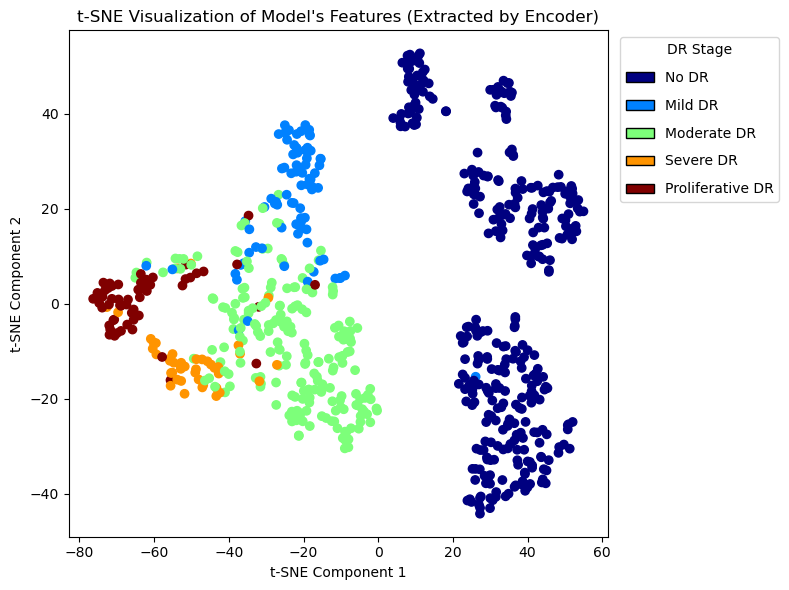

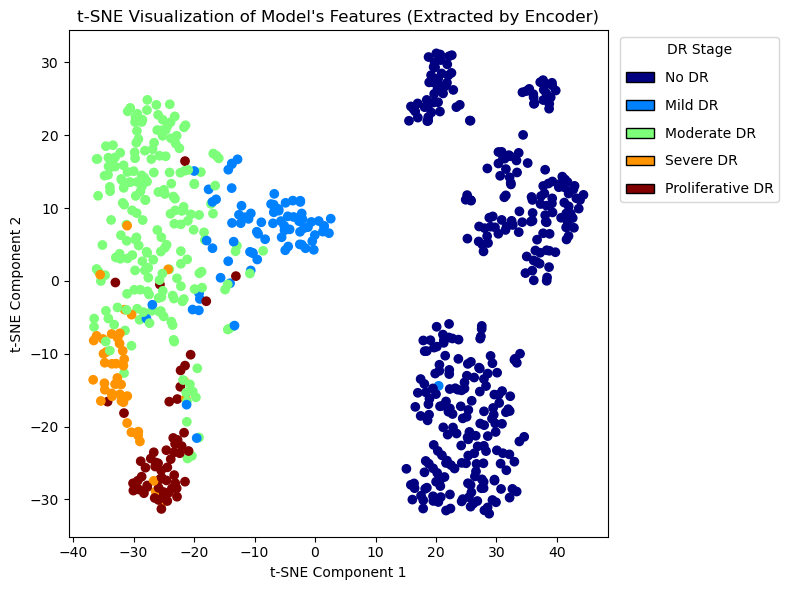

  2%|▎         | 1/40 [00:35<23:16, 35.81s/it]

Epoch: 1
loss_classification_train: 0.0773 | loss_regression_train: 0.1927 | loss_ordinal_train: 0.0168
loss_classification_validation: 0.0417 | loss_regression_validation: 0.1289 | loss_ordinal_validation: 0.0096
acc_classification_validation: 0.9737 | acc_regression_validation: 0.8535 | acc_ordinal_validation: 0.9737



  5%|▌         | 2/40 [00:43<12:23, 19.55s/it]

Epoch: 2
loss_classification_train: 0.0687 | loss_regression_train: 0.1579 | loss_ordinal_train: 0.0152
loss_classification_validation: 0.0402 | loss_regression_validation: 0.1147 | loss_ordinal_validation: 0.0091
acc_classification_validation: 0.9690 | acc_regression_validation: 0.9040 | acc_ordinal_validation: 0.9677



  8%|▊         | 3/40 [00:52<08:51, 14.36s/it]

Epoch: 3
loss_classification_train: 0.0661 | loss_regression_train: 0.1360 | loss_ordinal_train: 0.0154
loss_classification_validation: 0.0354 | loss_regression_validation: 0.0670 | loss_ordinal_validation: 0.0086
acc_classification_validation: 0.9750 | acc_regression_validation: 0.9480 | acc_ordinal_validation: 0.9737



 10%|█         | 4/40 [01:00<07:10, 11.95s/it]

Epoch: 4
loss_classification_train: 0.0485 | loss_regression_train: 0.1068 | loss_ordinal_train: 0.0106
loss_classification_validation: 0.0668 | loss_regression_validation: 0.0910 | loss_ordinal_validation: 0.0160
acc_classification_validation: 0.9594 | acc_regression_validation: 0.9563 | acc_ordinal_validation: 0.9594



 12%|█▎        | 5/40 [01:08<06:11, 10.62s/it]

Epoch: 5
loss_classification_train: 0.0589 | loss_regression_train: 0.1022 | loss_ordinal_train: 0.0139
loss_classification_validation: 0.0565 | loss_regression_validation: 0.0727 | loss_ordinal_validation: 0.0131
acc_classification_validation: 0.9508 | acc_regression_validation: 0.9534 | acc_ordinal_validation: 0.9534



 15%|█▌        | 6/40 [01:17<05:44, 10.14s/it]

Epoch: 6
loss_classification_train: 0.0616 | loss_regression_train: 0.0991 | loss_ordinal_train: 0.0139
loss_classification_validation: 0.0441 | loss_regression_validation: 0.0640 | loss_ordinal_validation: 0.0124
acc_classification_validation: 0.9698 | acc_regression_validation: 0.9563 | acc_ordinal_validation: 0.9672



 18%|█▊        | 7/40 [01:26<05:16,  9.59s/it]

Epoch: 7
loss_classification_train: 0.0498 | loss_regression_train: 0.0866 | loss_ordinal_train: 0.0121
loss_classification_validation: 0.0647 | loss_regression_validation: 0.0775 | loss_ordinal_validation: 0.0152
acc_classification_validation: 0.9532 | acc_regression_validation: 0.9467 | acc_ordinal_validation: 0.9545



 20%|██        | 8/40 [01:34<04:53,  9.16s/it]

Epoch: 8
loss_classification_train: 0.0568 | loss_regression_train: 0.0826 | loss_ordinal_train: 0.0117
loss_classification_validation: 0.0551 | loss_regression_validation: 0.0556 | loss_ordinal_validation: 0.0121
acc_classification_validation: 0.9729 | acc_regression_validation: 0.9638 | acc_ordinal_validation: 0.9716



 22%|██▎       | 9/40 [01:42<04:35,  8.90s/it]

Epoch: 9
loss_classification_train: 0.0606 | loss_regression_train: 0.0939 | loss_ordinal_train: 0.0135
loss_classification_validation: 0.0502 | loss_regression_validation: 0.0617 | loss_ordinal_validation: 0.0119
acc_classification_validation: 0.9651 | acc_regression_validation: 0.9625 | acc_ordinal_validation: 0.9612



 25%|██▌       | 10/40 [01:51<04:22,  8.75s/it]

Epoch: 10
loss_classification_train: 0.0554 | loss_regression_train: 0.0849 | loss_ordinal_train: 0.0108
loss_classification_validation: 0.0805 | loss_regression_validation: 0.0773 | loss_ordinal_validation: 0.0178
acc_classification_validation: 0.9561 | acc_regression_validation: 0.9376 | acc_ordinal_validation: 0.9522



 28%|██▊       | 11/40 [01:59<04:09,  8.61s/it]

Epoch: 11
loss_classification_train: 0.0510 | loss_regression_train: 0.0930 | loss_ordinal_train: 0.0113
loss_classification_validation: 0.0718 | loss_regression_validation: 0.0733 | loss_ordinal_validation: 0.0167
acc_classification_validation: 0.9633 | acc_regression_validation: 0.9423 | acc_ordinal_validation: 0.9607



 30%|███       | 12/40 [02:08<04:00,  8.58s/it]

Epoch: 12
loss_classification_train: 0.0520 | loss_regression_train: 0.0887 | loss_ordinal_train: 0.0118
loss_classification_validation: 0.0578 | loss_regression_validation: 0.0764 | loss_ordinal_validation: 0.0138
acc_classification_validation: 0.9628 | acc_regression_validation: 0.9506 | acc_ordinal_validation: 0.9659



 32%|███▎      | 13/40 [02:16<03:50,  8.53s/it]

Epoch: 13
loss_classification_train: 0.0437 | loss_regression_train: 0.0905 | loss_ordinal_train: 0.0107
loss_classification_validation: 0.0760 | loss_regression_validation: 0.0840 | loss_ordinal_validation: 0.0186
acc_classification_validation: 0.9594 | acc_regression_validation: 0.9480 | acc_ordinal_validation: 0.9589



 35%|███▌      | 14/40 [02:24<03:39,  8.44s/it]

Epoch: 14
loss_classification_train: 0.0371 | loss_regression_train: 0.0796 | loss_ordinal_train: 0.0091
loss_classification_validation: 0.0639 | loss_regression_validation: 0.0928 | loss_ordinal_validation: 0.0149
acc_classification_validation: 0.9620 | acc_regression_validation: 0.9188 | acc_ordinal_validation: 0.9630



 38%|███▊      | 15/40 [02:33<03:29,  8.40s/it]

Epoch: 15
loss_classification_train: 0.0460 | loss_regression_train: 0.1009 | loss_ordinal_train: 0.0096
loss_classification_validation: 0.0730 | loss_regression_validation: 0.1363 | loss_ordinal_validation: 0.0166
acc_classification_validation: 0.9553 | acc_regression_validation: 0.8739 | acc_ordinal_validation: 0.9558



 40%|████      | 16/40 [02:41<03:20,  8.36s/it]

Epoch: 16
loss_classification_train: 0.0525 | loss_regression_train: 0.1559 | loss_ordinal_train: 0.0127
loss_classification_validation: 0.0837 | loss_regression_validation: 0.1829 | loss_ordinal_validation: 0.0199
acc_classification_validation: 0.9623 | acc_regression_validation: 0.8674 | acc_ordinal_validation: 0.9587



 42%|████▎     | 17/40 [02:49<03:11,  8.34s/it]

Epoch: 17
loss_classification_train: 0.0539 | loss_regression_train: 0.1950 | loss_ordinal_train: 0.0111
loss_classification_validation: 0.0865 | loss_regression_validation: 0.1049 | loss_ordinal_validation: 0.0187
acc_classification_validation: 0.9547 | acc_regression_validation: 0.9417 | acc_ordinal_validation: 0.9516



 45%|████▌     | 18/40 [02:58<03:03,  8.35s/it]

Epoch: 18
loss_classification_train: 0.0446 | loss_regression_train: 0.1777 | loss_ordinal_train: 0.0098
loss_classification_validation: 0.1184 | loss_regression_validation: 0.1694 | loss_ordinal_validation: 0.0288
acc_classification_validation: 0.9553 | acc_regression_validation: 0.8972 | acc_ordinal_validation: 0.9540



 48%|████▊     | 19/40 [03:06<02:54,  8.32s/it]

Epoch: 19
loss_classification_train: 0.0529 | loss_regression_train: 0.1585 | loss_ordinal_train: 0.0117
loss_classification_validation: 0.0969 | loss_regression_validation: 0.1010 | loss_ordinal_validation: 0.0201
acc_classification_validation: 0.9524 | acc_regression_validation: 0.9347 | acc_ordinal_validation: 0.9524



 50%|█████     | 20/40 [03:14<02:46,  8.32s/it]

Epoch: 20
loss_classification_train: 0.0509 | loss_regression_train: 0.1105 | loss_ordinal_train: 0.0110
loss_classification_validation: 0.0736 | loss_regression_validation: 0.0788 | loss_ordinal_validation: 0.0175
acc_classification_validation: 0.9604 | acc_regression_validation: 0.9412 | acc_ordinal_validation: 0.9578



 52%|█████▎    | 21/40 [03:23<02:39,  8.38s/it]

Epoch: 21
loss_classification_train: 0.0420 | loss_regression_train: 0.0924 | loss_ordinal_train: 0.0095
loss_classification_validation: 0.1090 | loss_regression_validation: 0.1329 | loss_ordinal_validation: 0.0231
acc_classification_validation: 0.9402 | acc_regression_validation: 0.8923 | acc_ordinal_validation: 0.9459



 55%|█████▌    | 22/40 [03:31<02:30,  8.38s/it]

Epoch: 22
loss_classification_train: 0.0459 | loss_regression_train: 0.0888 | loss_ordinal_train: 0.0097
loss_classification_validation: 0.0908 | loss_regression_validation: 0.0954 | loss_ordinal_validation: 0.0191
acc_classification_validation: 0.9475 | acc_regression_validation: 0.9342 | acc_ordinal_validation: 0.9488



 57%|█████▊    | 23/40 [03:39<02:22,  8.38s/it]

Epoch: 23
loss_classification_train: 0.0395 | loss_regression_train: 0.0760 | loss_ordinal_train: 0.0091
loss_classification_validation: 0.1032 | loss_regression_validation: 0.0811 | loss_ordinal_validation: 0.0217
acc_classification_validation: 0.9472 | acc_regression_validation: 0.9386 | acc_ordinal_validation: 0.9451



 60%|██████    | 24/40 [03:48<02:13,  8.36s/it]

Epoch: 24
loss_classification_train: 0.0506 | loss_regression_train: 0.0887 | loss_ordinal_train: 0.0114
loss_classification_validation: 0.1162 | loss_regression_validation: 0.1064 | loss_ordinal_validation: 0.0252
acc_classification_validation: 0.9438 | acc_regression_validation: 0.9235 | acc_ordinal_validation: 0.9446



 62%|██████▎   | 25/40 [03:56<02:05,  8.34s/it]

Epoch: 25
loss_classification_train: 0.0456 | loss_regression_train: 0.0803 | loss_ordinal_train: 0.0104
loss_classification_validation: 0.1256 | loss_regression_validation: 0.0932 | loss_ordinal_validation: 0.0232
acc_classification_validation: 0.9438 | acc_regression_validation: 0.9279 | acc_ordinal_validation: 0.9428



 65%|██████▌   | 26/40 [04:04<01:56,  8.32s/it]

Epoch: 26
loss_classification_train: 0.0378 | loss_regression_train: 0.0774 | loss_ordinal_train: 0.0088
loss_classification_validation: 0.0934 | loss_regression_validation: 0.0749 | loss_ordinal_validation: 0.0188
acc_classification_validation: 0.9556 | acc_regression_validation: 0.9316 | acc_ordinal_validation: 0.9504



 68%|██████▊   | 27/40 [04:12<01:47,  8.30s/it]

Epoch: 27
loss_classification_train: 0.0397 | loss_regression_train: 0.0826 | loss_ordinal_train: 0.0085
loss_classification_validation: 0.0888 | loss_regression_validation: 0.0777 | loss_ordinal_validation: 0.0184
acc_classification_validation: 0.9532 | acc_regression_validation: 0.9527 | acc_ordinal_validation: 0.9558



 70%|███████   | 28/40 [04:21<01:39,  8.30s/it]

Epoch: 28
loss_classification_train: 0.0435 | loss_regression_train: 0.0977 | loss_ordinal_train: 0.0095
loss_classification_validation: 0.1344 | loss_regression_validation: 0.1496 | loss_ordinal_validation: 0.0285
acc_classification_validation: 0.9389 | acc_regression_validation: 0.9118 | acc_ordinal_validation: 0.9357



 72%|███████▎  | 29/40 [04:29<01:31,  8.30s/it]

Epoch: 29
loss_classification_train: 0.0395 | loss_regression_train: 0.1206 | loss_ordinal_train: 0.0096
loss_classification_validation: 0.1309 | loss_regression_validation: 0.1260 | loss_ordinal_validation: 0.0263
acc_classification_validation: 0.9378 | acc_regression_validation: 0.9339 | acc_ordinal_validation: 0.9417



 75%|███████▌  | 30/40 [04:37<01:23,  8.30s/it]

Epoch: 30
loss_classification_train: 0.0529 | loss_regression_train: 0.1116 | loss_ordinal_train: 0.0114
loss_classification_validation: 0.1207 | loss_regression_validation: 0.1059 | loss_ordinal_validation: 0.0254
acc_classification_validation: 0.9457 | acc_regression_validation: 0.9155 | acc_ordinal_validation: 0.9430



 78%|███████▊  | 31/40 [04:46<01:14,  8.29s/it]

Epoch: 31
loss_classification_train: 0.0395 | loss_regression_train: 0.1037 | loss_ordinal_train: 0.0096
loss_classification_validation: 0.1253 | loss_regression_validation: 0.2015 | loss_ordinal_validation: 0.0293
acc_classification_validation: 0.9360 | acc_regression_validation: 0.8787 | acc_ordinal_validation: 0.9386



 80%|████████  | 32/40 [04:54<01:06,  8.30s/it]

Epoch: 32
loss_classification_train: 0.0460 | loss_regression_train: 0.1263 | loss_ordinal_train: 0.0114
loss_classification_validation: 0.0987 | loss_regression_validation: 0.1633 | loss_ordinal_validation: 0.0208
acc_classification_validation: 0.9511 | acc_regression_validation: 0.8566 | acc_ordinal_validation: 0.9493



 82%|████████▎ | 33/40 [05:02<00:58,  8.30s/it]

Epoch: 33
loss_classification_train: 0.0560 | loss_regression_train: 0.1608 | loss_ordinal_train: 0.0121
loss_classification_validation: 0.1735 | loss_regression_validation: 0.1931 | loss_ordinal_validation: 0.0349
acc_classification_validation: 0.9173 | acc_regression_validation: 0.8791 | acc_ordinal_validation: 0.9160



 85%|████████▌ | 34/40 [05:11<00:49,  8.31s/it]

Epoch: 34
loss_classification_train: 0.0536 | loss_regression_train: 0.1276 | loss_ordinal_train: 0.0113
loss_classification_validation: 0.1652 | loss_regression_validation: 0.1488 | loss_ordinal_validation: 0.0385
acc_classification_validation: 0.9269 | acc_regression_validation: 0.9121 | acc_ordinal_validation: 0.9292



 88%|████████▊ | 35/40 [05:19<00:41,  8.32s/it]

Epoch: 35
loss_classification_train: 0.0458 | loss_regression_train: 0.0919 | loss_ordinal_train: 0.0098
loss_classification_validation: 0.1531 | loss_regression_validation: 0.1314 | loss_ordinal_validation: 0.0349
acc_classification_validation: 0.9430 | acc_regression_validation: 0.9339 | acc_ordinal_validation: 0.9397



 90%|█████████ | 36/40 [05:27<00:33,  8.29s/it]

Epoch: 36
loss_classification_train: 0.0394 | loss_regression_train: 0.0871 | loss_ordinal_train: 0.0094
loss_classification_validation: 0.1320 | loss_regression_validation: 0.1194 | loss_ordinal_validation: 0.0295
acc_classification_validation: 0.9383 | acc_regression_validation: 0.9209 | acc_ordinal_validation: 0.9357



 92%|█████████▎| 37/40 [05:36<00:24,  8.30s/it]

Epoch: 37
loss_classification_train: 0.0376 | loss_regression_train: 0.0831 | loss_ordinal_train: 0.0084
loss_classification_validation: 0.1488 | loss_regression_validation: 0.1178 | loss_ordinal_validation: 0.0317
acc_classification_validation: 0.9331 | acc_regression_validation: 0.9110 | acc_ordinal_validation: 0.9350



 95%|█████████▌| 38/40 [05:44<00:16,  8.30s/it]

Epoch: 38
loss_classification_train: 0.0313 | loss_regression_train: 0.0686 | loss_ordinal_train: 0.0076
loss_classification_validation: 0.1545 | loss_regression_validation: 0.1243 | loss_ordinal_validation: 0.0329
acc_classification_validation: 0.9344 | acc_regression_validation: 0.9222 | acc_ordinal_validation: 0.9350



 98%|█████████▊| 39/40 [05:52<00:08,  8.30s/it]

Epoch: 39
loss_classification_train: 0.0318 | loss_regression_train: 0.0781 | loss_ordinal_train: 0.0079
loss_classification_validation: 0.1661 | loss_regression_validation: 0.1300 | loss_ordinal_validation: 0.0343
acc_classification_validation: 0.9269 | acc_regression_validation: 0.9235 | acc_ordinal_validation: 0.9269



100%|██████████| 40/40 [06:00<00:00,  9.02s/it]

Epoch: 40
loss_classification_train: 0.0463 | loss_regression_train: 0.0955 | loss_ordinal_train: 0.0117
loss_classification_validation: 0.1189 | loss_regression_validation: 0.1094 | loss_ordinal_validation: 0.0239
acc_classification_validation: 0.9436 | acc_regression_validation: 0.9206 | acc_ordinal_validation: 0.9511



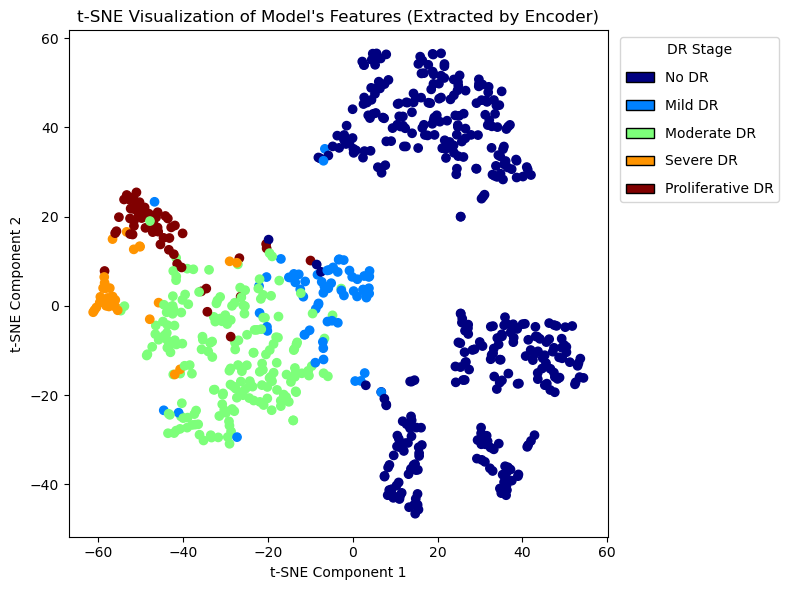

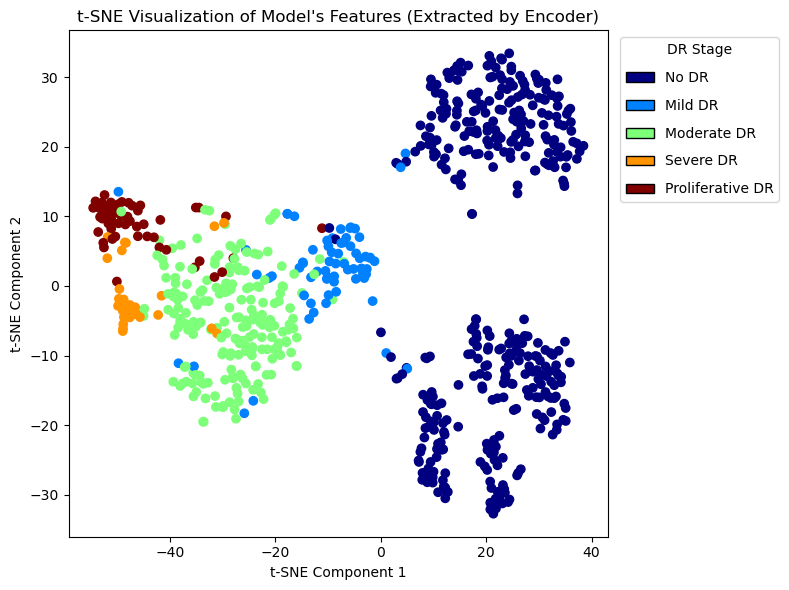

  2%|▎         | 1/40 [00:35<23:19, 35.87s/it]

Epoch: 1
loss_classification_train: 0.0665 | loss_regression_train: 0.1261 | loss_ordinal_train: 0.0151
loss_classification_validation: 0.0660 | loss_regression_validation: 0.1275 | loss_ordinal_validation: 0.0138
acc_classification_validation: 0.9589 | acc_regression_validation: 0.8959 | acc_ordinal_validation: 0.9615



  5%|▌         | 2/40 [00:44<12:28, 19.71s/it]

Epoch: 2
loss_classification_train: 0.0526 | loss_regression_train: 0.1487 | loss_ordinal_train: 0.0120
loss_classification_validation: 0.0231 | loss_regression_validation: 0.1201 | loss_ordinal_validation: 0.0049
acc_classification_validation: 0.9787 | acc_regression_validation: 0.8728 | acc_ordinal_validation: 0.9839



  8%|▊         | 3/40 [00:52<08:57, 14.52s/it]

Epoch: 3
loss_classification_train: 0.0526 | loss_regression_train: 0.1500 | loss_ordinal_train: 0.0113
loss_classification_validation: 0.0302 | loss_regression_validation: 0.0719 | loss_ordinal_validation: 0.0065
acc_classification_validation: 0.9808 | acc_regression_validation: 0.9310 | acc_ordinal_validation: 0.9821



 10%|█         | 4/40 [01:01<07:16, 12.14s/it]

Epoch: 4
loss_classification_train: 0.0451 | loss_regression_train: 0.1427 | loss_ordinal_train: 0.0100
loss_classification_validation: 0.0395 | loss_regression_validation: 0.0846 | loss_ordinal_validation: 0.0087
acc_classification_validation: 0.9761 | acc_regression_validation: 0.9493 | acc_ordinal_validation: 0.9742



 12%|█▎        | 5/40 [01:09<06:17, 10.78s/it]

Epoch: 5
loss_classification_train: 0.0386 | loss_regression_train: 0.1294 | loss_ordinal_train: 0.0088
loss_classification_validation: 0.0439 | loss_regression_validation: 0.0944 | loss_ordinal_validation: 0.0089
acc_classification_validation: 0.9706 | acc_regression_validation: 0.9441 | acc_ordinal_validation: 0.9750



 15%|█▌        | 6/40 [01:17<05:39,  9.98s/it]

Epoch: 6
loss_classification_train: 0.0522 | loss_regression_train: 0.0938 | loss_ordinal_train: 0.0124
loss_classification_validation: 0.0385 | loss_regression_validation: 0.0425 | loss_ordinal_validation: 0.0078
acc_classification_validation: 0.9685 | acc_regression_validation: 0.9641 | acc_ordinal_validation: 0.9667



 18%|█▊        | 7/40 [01:26<05:12,  9.48s/it]

Epoch: 7
loss_classification_train: 0.0451 | loss_regression_train: 0.0769 | loss_ordinal_train: 0.0096
loss_classification_validation: 0.0604 | loss_regression_validation: 0.0657 | loss_ordinal_validation: 0.0135
acc_classification_validation: 0.9633 | acc_regression_validation: 0.9449 | acc_ordinal_validation: 0.9628



 20%|██        | 8/40 [01:34<04:52,  9.15s/it]

Epoch: 8
loss_classification_train: 0.0418 | loss_regression_train: 0.0885 | loss_ordinal_train: 0.0106
loss_classification_validation: 0.0364 | loss_regression_validation: 0.0417 | loss_ordinal_validation: 0.0079
acc_classification_validation: 0.9800 | acc_regression_validation: 0.9573 | acc_ordinal_validation: 0.9800



 22%|██▎       | 9/40 [01:43<04:36,  8.92s/it]

Epoch: 9
loss_classification_train: 0.0409 | loss_regression_train: 0.0818 | loss_ordinal_train: 0.0101
loss_classification_validation: 0.0650 | loss_regression_validation: 0.0592 | loss_ordinal_validation: 0.0139
acc_classification_validation: 0.9607 | acc_regression_validation: 0.9612 | acc_ordinal_validation: 0.9581



 25%|██▌       | 10/40 [01:51<04:23,  8.80s/it]

Epoch: 10
loss_classification_train: 0.0507 | loss_regression_train: 0.0792 | loss_ordinal_train: 0.0116
loss_classification_validation: 0.0469 | loss_regression_validation: 0.0306 | loss_ordinal_validation: 0.0088
acc_classification_validation: 0.9706 | acc_regression_validation: 0.9677 | acc_ordinal_validation: 0.9719



 28%|██▊       | 11/40 [02:00<04:12,  8.70s/it]

Epoch: 11
loss_classification_train: 0.0559 | loss_regression_train: 0.0959 | loss_ordinal_train: 0.0128
loss_classification_validation: 0.0525 | loss_regression_validation: 0.0614 | loss_ordinal_validation: 0.0105
acc_classification_validation: 0.9644 | acc_regression_validation: 0.9394 | acc_ordinal_validation: 0.9649



 30%|███       | 12/40 [02:08<04:01,  8.64s/it]

Epoch: 12
loss_classification_train: 0.0586 | loss_regression_train: 0.1056 | loss_ordinal_train: 0.0133
loss_classification_validation: 0.0757 | loss_regression_validation: 0.1020 | loss_ordinal_validation: 0.0152
acc_classification_validation: 0.9555 | acc_regression_validation: 0.8983 | acc_ordinal_validation: 0.9516



 32%|███▎      | 13/40 [02:17<03:52,  8.62s/it]

Epoch: 13
loss_classification_train: 0.0591 | loss_regression_train: 0.1233 | loss_ordinal_train: 0.0139
loss_classification_validation: 0.0565 | loss_regression_validation: 0.0682 | loss_ordinal_validation: 0.0114
acc_classification_validation: 0.9664 | acc_regression_validation: 0.9438 | acc_ordinal_validation: 0.9659



 35%|███▌      | 14/40 [02:25<03:42,  8.56s/it]

Epoch: 14
loss_classification_train: 0.0539 | loss_regression_train: 0.0988 | loss_ordinal_train: 0.0127
loss_classification_validation: 0.0484 | loss_regression_validation: 0.0461 | loss_ordinal_validation: 0.0087
acc_classification_validation: 0.9724 | acc_regression_validation: 0.9664 | acc_ordinal_validation: 0.9742



 38%|███▊      | 15/40 [02:34<03:33,  8.53s/it]

Epoch: 15
loss_classification_train: 0.0384 | loss_regression_train: 0.0782 | loss_ordinal_train: 0.0089
loss_classification_validation: 0.0418 | loss_regression_validation: 0.0353 | loss_ordinal_validation: 0.0077
acc_classification_validation: 0.9755 | acc_regression_validation: 0.9695 | acc_ordinal_validation: 0.9755



 40%|████      | 16/40 [02:42<03:24,  8.52s/it]

Epoch: 16
loss_classification_train: 0.0394 | loss_regression_train: 0.0742 | loss_ordinal_train: 0.0097
loss_classification_validation: 0.0354 | loss_regression_validation: 0.0292 | loss_ordinal_validation: 0.0077
acc_classification_validation: 0.9774 | acc_regression_validation: 0.9656 | acc_ordinal_validation: 0.9800



 42%|████▎     | 17/40 [02:51<03:15,  8.48s/it]

Epoch: 17
loss_classification_train: 0.0330 | loss_regression_train: 0.0845 | loss_ordinal_train: 0.0086
loss_classification_validation: 0.0616 | loss_regression_validation: 0.0791 | loss_ordinal_validation: 0.0125
acc_classification_validation: 0.9638 | acc_regression_validation: 0.9368 | acc_ordinal_validation: 0.9599



 45%|████▌     | 18/40 [02:59<03:06,  8.47s/it]

Epoch: 18
loss_classification_train: 0.0355 | loss_regression_train: 0.1194 | loss_ordinal_train: 0.0080
loss_classification_validation: 0.0588 | loss_regression_validation: 0.1578 | loss_ordinal_validation: 0.0118
acc_classification_validation: 0.9646 | acc_regression_validation: 0.8944 | acc_ordinal_validation: 0.9633



 48%|████▊     | 19/40 [03:07<02:57,  8.44s/it]

Epoch: 19
loss_classification_train: 0.0343 | loss_regression_train: 0.1280 | loss_ordinal_train: 0.0073
loss_classification_validation: 0.0550 | loss_regression_validation: 0.0728 | loss_ordinal_validation: 0.0101
acc_classification_validation: 0.9724 | acc_regression_validation: 0.9376 | acc_ordinal_validation: 0.9698



 50%|█████     | 20/40 [03:16<02:49,  8.45s/it]

Epoch: 20
loss_classification_train: 0.0489 | loss_regression_train: 0.1064 | loss_ordinal_train: 0.0113
loss_classification_validation: 0.0607 | loss_regression_validation: 0.0514 | loss_ordinal_validation: 0.0125
acc_classification_validation: 0.9649 | acc_regression_validation: 0.9584 | acc_ordinal_validation: 0.9662



 52%|█████▎    | 21/40 [03:24<02:39,  8.42s/it]

Epoch: 21
loss_classification_train: 0.0362 | loss_regression_train: 0.0817 | loss_ordinal_train: 0.0085
loss_classification_validation: 0.0694 | loss_regression_validation: 0.0856 | loss_ordinal_validation: 0.0159
acc_classification_validation: 0.9633 | acc_regression_validation: 0.9316 | acc_ordinal_validation: 0.9659



 55%|█████▌    | 22/40 [03:33<02:31,  8.39s/it]

Epoch: 22
loss_classification_train: 0.0474 | loss_regression_train: 0.0842 | loss_ordinal_train: 0.0104
loss_classification_validation: 0.0466 | loss_regression_validation: 0.0480 | loss_ordinal_validation: 0.0092
acc_classification_validation: 0.9748 | acc_regression_validation: 0.9604 | acc_ordinal_validation: 0.9761



 57%|█████▊    | 23/40 [03:41<02:22,  8.37s/it]

Epoch: 23
loss_classification_train: 0.0324 | loss_regression_train: 0.0634 | loss_ordinal_train: 0.0074
loss_classification_validation: 0.0845 | loss_regression_validation: 0.0597 | loss_ordinal_validation: 0.0154
acc_classification_validation: 0.9685 | acc_regression_validation: 0.9545 | acc_ordinal_validation: 0.9659



 60%|██████    | 24/40 [03:49<02:13,  8.35s/it]

Epoch: 24
loss_classification_train: 0.0398 | loss_regression_train: 0.0763 | loss_ordinal_train: 0.0083
loss_classification_validation: 0.1000 | loss_regression_validation: 0.0654 | loss_ordinal_validation: 0.0179
acc_classification_validation: 0.9496 | acc_regression_validation: 0.9407 | acc_ordinal_validation: 0.9464



 62%|██████▎   | 25/40 [03:57<02:05,  8.35s/it]

Epoch: 25
loss_classification_train: 0.0326 | loss_regression_train: 0.0767 | loss_ordinal_train: 0.0076
loss_classification_validation: 0.0948 | loss_regression_validation: 0.0827 | loss_ordinal_validation: 0.0184
acc_classification_validation: 0.9459 | acc_regression_validation: 0.9271 | acc_ordinal_validation: 0.9433



 65%|██████▌   | 26/40 [04:06<01:56,  8.34s/it]

Epoch: 26
loss_classification_train: 0.0380 | loss_regression_train: 0.0780 | loss_ordinal_train: 0.0094
loss_classification_validation: 0.0723 | loss_regression_validation: 0.0574 | loss_ordinal_validation: 0.0153
acc_classification_validation: 0.9568 | acc_regression_validation: 0.9404 | acc_ordinal_validation: 0.9524



 68%|██████▊   | 27/40 [04:14<01:48,  8.32s/it]

Epoch: 27
loss_classification_train: 0.0353 | loss_regression_train: 0.0868 | loss_ordinal_train: 0.0092
loss_classification_validation: 0.0572 | loss_regression_validation: 0.0481 | loss_ordinal_validation: 0.0118
acc_classification_validation: 0.9662 | acc_regression_validation: 0.9488 | acc_ordinal_validation: 0.9649



 70%|███████   | 28/40 [04:23<01:40,  8.35s/it]

Epoch: 28
loss_classification_train: 0.0516 | loss_regression_train: 0.0968 | loss_ordinal_train: 0.0108
loss_classification_validation: 0.1374 | loss_regression_validation: 0.0937 | loss_ordinal_validation: 0.0238
acc_classification_validation: 0.9152 | acc_regression_validation: 0.9274 | acc_ordinal_validation: 0.9245



 72%|███████▎  | 29/40 [04:31<01:31,  8.33s/it]

Epoch: 29
loss_classification_train: 0.0505 | loss_regression_train: 0.1286 | loss_ordinal_train: 0.0110
loss_classification_validation: 0.0899 | loss_regression_validation: 0.0998 | loss_ordinal_validation: 0.0170
acc_classification_validation: 0.9479 | acc_regression_validation: 0.9284 | acc_ordinal_validation: 0.9544



 75%|███████▌  | 30/40 [04:39<01:23,  8.31s/it]

Epoch: 30
loss_classification_train: 0.0366 | loss_regression_train: 0.1333 | loss_ordinal_train: 0.0085
loss_classification_validation: 0.0803 | loss_regression_validation: 0.0801 | loss_ordinal_validation: 0.0167
acc_classification_validation: 0.9605 | acc_regression_validation: 0.9313 | acc_ordinal_validation: 0.9566



 78%|███████▊  | 31/40 [04:47<01:14,  8.29s/it]

Epoch: 31
loss_classification_train: 0.0409 | loss_regression_train: 0.1372 | loss_ordinal_train: 0.0095
loss_classification_validation: 0.0956 | loss_regression_validation: 0.1430 | loss_ordinal_validation: 0.0187
acc_classification_validation: 0.9433 | acc_regression_validation: 0.8546 | acc_ordinal_validation: 0.9441



 80%|████████  | 32/40 [04:56<01:06,  8.31s/it]

Epoch: 32
loss_classification_train: 0.0380 | loss_regression_train: 0.0929 | loss_ordinal_train: 0.0093
loss_classification_validation: 0.1024 | loss_regression_validation: 0.0825 | loss_ordinal_validation: 0.0180
acc_classification_validation: 0.9438 | acc_regression_validation: 0.9094 | acc_ordinal_validation: 0.9477



 82%|████████▎ | 33/40 [05:04<00:58,  8.33s/it]

Epoch: 33
loss_classification_train: 0.0358 | loss_regression_train: 0.0781 | loss_ordinal_train: 0.0089
loss_classification_validation: 0.1117 | loss_regression_validation: 0.0662 | loss_ordinal_validation: 0.0212
acc_classification_validation: 0.9451 | acc_regression_validation: 0.9363 | acc_ordinal_validation: 0.9503



 85%|████████▌ | 34/40 [05:12<00:50,  8.36s/it]

Epoch: 34
loss_classification_train: 0.0379 | loss_regression_train: 0.0859 | loss_ordinal_train: 0.0084
loss_classification_validation: 0.1143 | loss_regression_validation: 0.0962 | loss_ordinal_validation: 0.0216
acc_classification_validation: 0.9428 | acc_regression_validation: 0.9235 | acc_ordinal_validation: 0.9415



 88%|████████▊ | 35/40 [05:21<00:41,  8.33s/it]

Epoch: 35
loss_classification_train: 0.0406 | loss_regression_train: 0.1009 | loss_ordinal_train: 0.0091
loss_classification_validation: 0.1088 | loss_regression_validation: 0.0930 | loss_ordinal_validation: 0.0195
acc_classification_validation: 0.9472 | acc_regression_validation: 0.9329 | acc_ordinal_validation: 0.9415



 90%|█████████ | 36/40 [05:29<00:33,  8.30s/it]

Epoch: 36
loss_classification_train: 0.0373 | loss_regression_train: 0.1132 | loss_ordinal_train: 0.0083
loss_classification_validation: 0.1173 | loss_regression_validation: 0.1123 | loss_ordinal_validation: 0.0216
acc_classification_validation: 0.9350 | acc_regression_validation: 0.9084 | acc_ordinal_validation: 0.9376



 92%|█████████▎| 37/40 [05:37<00:24,  8.32s/it]

Epoch: 37
loss_classification_train: 0.0376 | loss_regression_train: 0.1067 | loss_ordinal_train: 0.0092
loss_classification_validation: 0.1158 | loss_regression_validation: 0.1110 | loss_ordinal_validation: 0.0239
acc_classification_validation: 0.9357 | acc_regression_validation: 0.8874 | acc_ordinal_validation: 0.9410



 95%|█████████▌| 38/40 [05:46<00:16,  8.33s/it]

Epoch: 38
loss_classification_train: 0.0519 | loss_regression_train: 0.1435 | loss_ordinal_train: 0.0143
loss_classification_validation: 0.1481 | loss_regression_validation: 0.1731 | loss_ordinal_validation: 0.0299
acc_classification_validation: 0.9212 | acc_regression_validation: 0.8335 | acc_ordinal_validation: 0.9173



 98%|█████████▊| 39/40 [05:54<00:08,  8.34s/it]

Epoch: 39
loss_classification_train: 0.0583 | loss_regression_train: 0.1530 | loss_ordinal_train: 0.0143
loss_classification_validation: 0.1457 | loss_regression_validation: 0.1290 | loss_ordinal_validation: 0.0260
acc_classification_validation: 0.9243 | acc_regression_validation: 0.8642 | acc_ordinal_validation: 0.9211



100%|██████████| 40/40 [06:03<00:00,  9.08s/it]

Epoch: 40
loss_classification_train: 0.0493 | loss_regression_train: 0.1273 | loss_ordinal_train: 0.0117
loss_classification_validation: 0.0879 | loss_regression_validation: 0.0741 | loss_ordinal_validation: 0.0174
acc_classification_validation: 0.9381 | acc_regression_validation: 0.9240 | acc_ordinal_validation: 0.9420



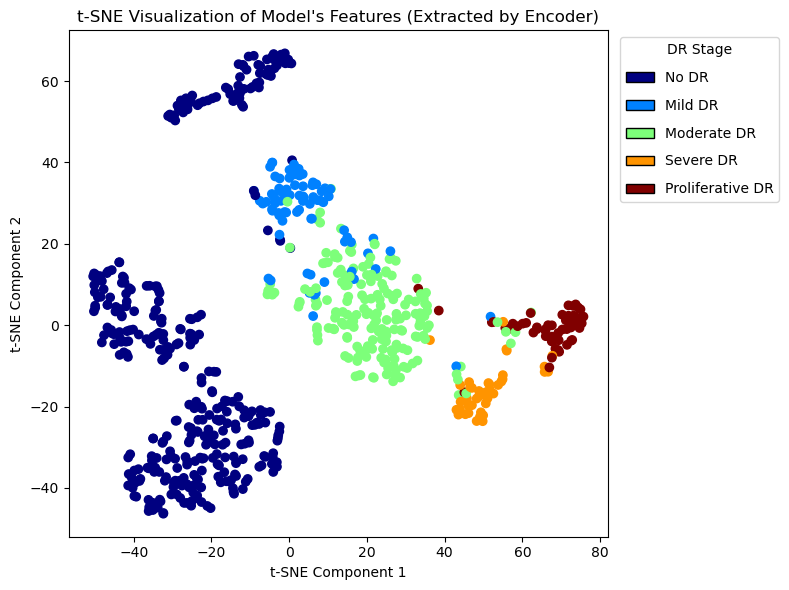

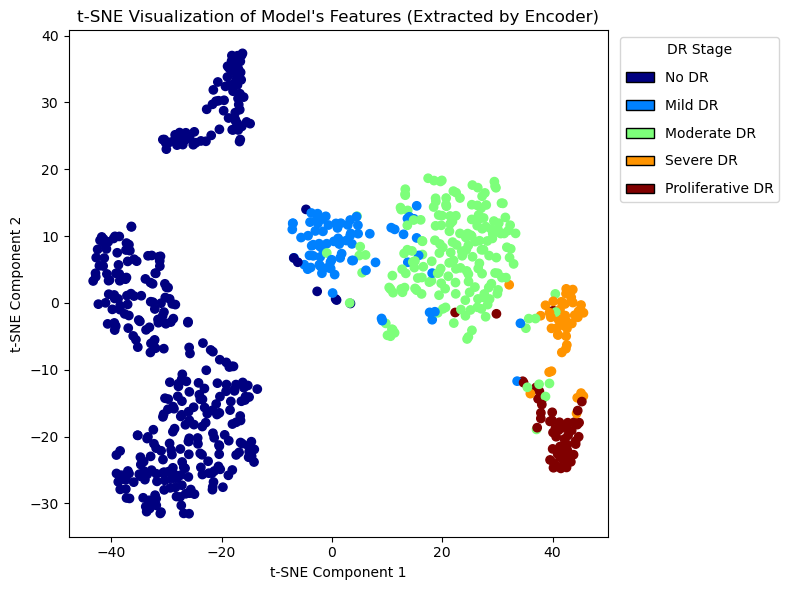

[INFO] Total training time: 1842.603 seconds
[INFO] Saving model to: models\main_train_model.pth


In [14]:
folds_train_results = {
    'loss_classification_train': [],
    'loss_regression_train': [],
    'loss_ordinal_train': []
}
folds_val_results = {
    'loss_classification_val': [],
    'loss_regression_val': [],
    'loss_ordinal_val': []
}
if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for fold in train_val_dataloader:
        train_results, val_results = engine.train(model=model,
                            train_dataloader=fold['train_dataloader'],
                            val_dataloader=fold['val_dataloader'],
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn_classification=loss_fn_classification,
                            loss_fn_regression=loss_fn_regression,
                            loss_fn_ordinal=loss_fn_ordinal,
                            epochs=EPOCHS,
                            device=device)
        
        # helper_functions.plot_loss_curves(results)
        folds_train_results['loss_classification_train'].extend(train_results['loss_classification_train'])
        folds_train_results['loss_regression_train'].extend(train_results['loss_regression_train'])
        folds_train_results['loss_ordinal_train'].extend(train_results['loss_ordinal_train'])

        folds_val_results['loss_classification_val'].extend(val_results['loss_classification_val'])
        folds_val_results['loss_regression_val'].extend(val_results['loss_regression_val'])
        folds_val_results['loss_ordinal_val'].extend(val_results['loss_ordinal_val'])

        helper_functions.plot_t_SNE(model=model,
                                dataloader=fold['val_dataloader'],
                                NUM_ITER=2000)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='main_train_model.pth')
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

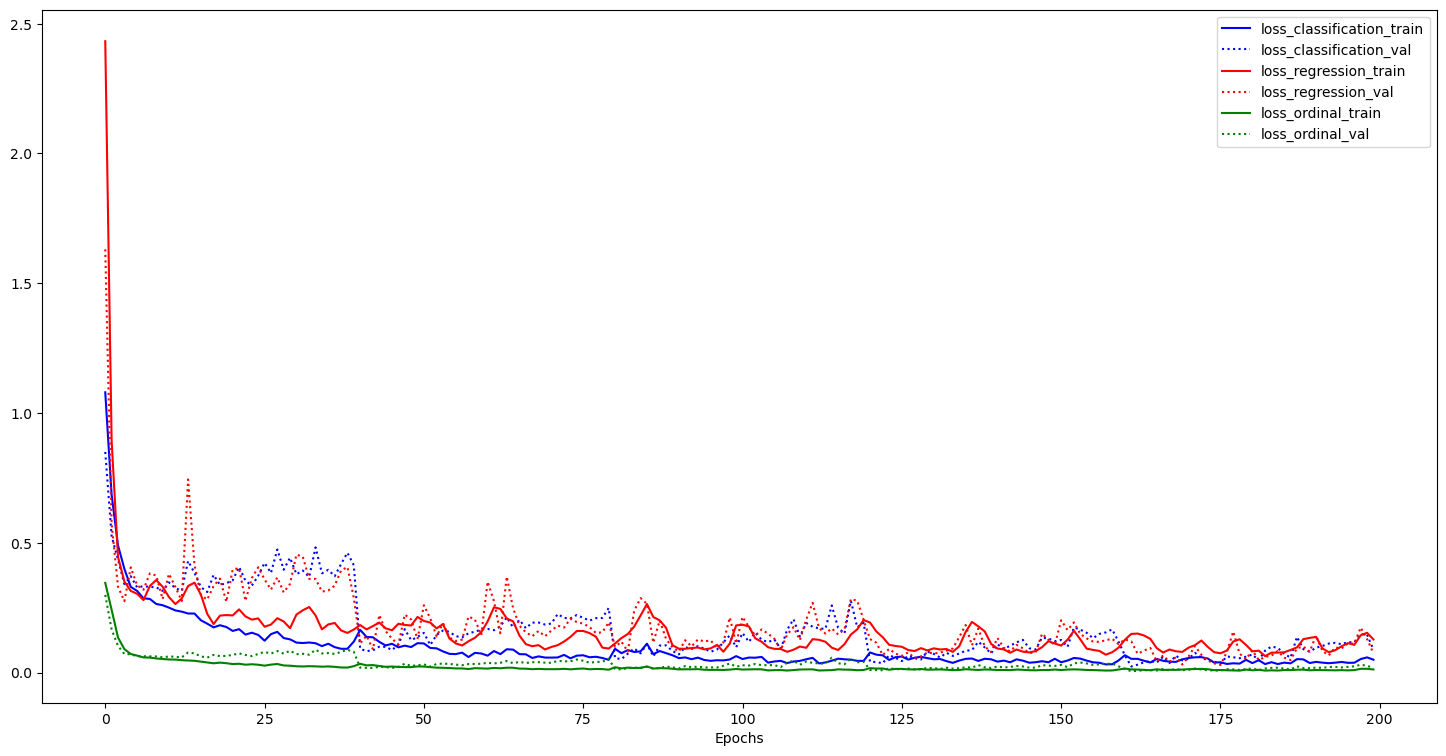

In [15]:
if allow_train:
    helper_functions.plot_loss_curves_main_train(folds_train_results, folds_val_results)

In [16]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn_classification=loss_fn_classification,
            loss_fn_regression=loss_fn_regression,
            loss_fn_ordinal=loss_fn_ordinal,
            device=device)

f1_class: tensor([8.5853e-01, 3.6717e-04, 1.1436e-01, 1.1933e-03, 9.3144e-02]) | f1_reg: tensor([0.8591, 0.0072, 0.1006, 0.0123, 0.0560]) | f1_ord: tensor([0.8585, 0.0030, 0.1004, 0.0026, 0.0776])
test class acc: 0.7456431483691329 | test reg acc: 0.7383713703261735 | test ord acc: 0.7428836018297534


In [17]:
# helper_functions.plot_t_SNE(model=model,
#                             dataloader=test_dataloader,
#                             NUM_ITER=2000)